In [1]:
import pyarrow as pa
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import csv
%matplotlib inline

Load signal and background files

In [2]:
identifier = '20220208_no_qual_no_iso' # old Z+jets
identifier = '20220216_no_qual_no_iso' # new Z+jets

sig = pd.read_feather('/home/grabanal/minitree/{}_VVZ.arrow'.format(identifier))
bkg = pd.read_feather('/home/grabanal/minitree/{}_FULLBG.arrow'.format(identifier))

In [86]:
ZZ = pd.read_feather('/home/grabanal/minitree/{}_ZZ.arrow'.format(identifier))
WZ = pd.read_feather('/home/grabanal/minitree/{}_WZ.arrow'.format(identifier))
Zjets = pd.read_feather('/home/grabanal/minitree/{}_Zjets.arrow'.format(identifier))
Zgamma = pd.read_feather('/home/grabanal/minitree/{}_Zgamma.arrow'.format(identifier))
ttZ = pd.read_feather('/home/grabanal/minitree/{}_ttZ.arrow'.format(identifier))
tZ = pd.read_feather('/home/grabanal/minitree/{}_tZ.arrow'.format(identifier))
tWZ = pd.read_feather('/home/grabanal/minitree/{}_tWZ.arrow'.format(identifier))
others = pd.read_feather('/home/grabanal/minitree/{}_others.arrow'.format(identifier))

In [87]:
sumwgt = 0

backgrounds = [ZZ, WZ, Zjets, Zgamma, ttZ, tZ, tWZ, others]
for df in backgrounds:
    sumwgt += sum(df['wgt'])
    
print(sumwgt)

5720.020506531861


In [3]:
sig = sig[sig.SR == 2]
bkg = bkg[bkg.SR == 2]

Simple check

In [4]:
print('VVZ signal yield:', sum(sig.wgt))
print('background yield:', sum(bkg.wgt))

VVZ signal yield: 18.206449137385114
background yield: 1130.7377681416792


Define basic functions

In [5]:
def yield_and_error(df):
    '''
    input: 
    df  : dataframe
    
    output:
    yield (significance, error)
    '''
    Y  = -1
    dY = -1
    Y  = sum(df.wgt)
    dY = np.sqrt(sum(df.wgt**2))
    # return tuple
    return Y, dY

def significance_and_error(S, dS, B, dB):
    '''
    input: 
    S  : signal
    dS : signal error
    B  : background
    dB : background error
    
    output:
    tuple (significance, error)
    '''
    # FAKE SIGNIFICANCE
#     significance = S/np.sqrt(B)
#     error        = np.sqrt( 1/B*(dS**2) + (S**2)/(4*B**3)*(dB**2) )
#     return significance, error
    
    # REAL SIGNIFICANCE
    # if a quantity is negative, return 0
    if (S<=0 or B<=0):
        return 0, 0
    # calculate the significance and its error
    significance = np.sqrt( 2*((S + B)*np.log(1 + S/B) - S) )
    dSignifdS    = np.log(1 + S/B)/significance
    dSignifdB    = ( np.log(1 + S/B) - S/B )/significance
    error        = np.sqrt( (dSignifdS*dS)**2 + (dSignifdB*dB)**2 )
    # return tuple
    return significance, error

def add_in_quadrature_3( XdX, YdY, ZdZ ):
    '''
    input: 
    XdX : tuple (significance, error)
    YdY : tuple (significance, error)
    ZdZ : tuple (significance, error)
    
    output:
    tuple (significance, error) added in quadrature
    '''
    # unpack the significances
    x, dx = XdX
    y, dy = YdY
    z, dz = ZdZ
    # calculate the addition in quadrature and its error
    quadrature_sum   = np.sqrt(x**2 + y**2 + z**2)
    A                = (x**2)*(dx**2) + (y**2)*(dy**2) + (z**2)*(dz**2)
    B                = (x**2) + (y**2) + (z**2)
    if (quadrature_sum==0):
        return 0, 0
    quadrature_error = np.sqrt( A / B )
    # return tuple
    return quadrature_sum, quadrature_error

def total_significance_and_error( df_sig, df_bg ):
    
    m_list = []
    for sr in [0,1,2]:
        S, dS = yield_and_error(df_sig[df_sig.SR == sr])
        B, dB = yield_and_error( df_bg[ df_bg.SR == sr])
        m_list.append(significance_and_error(S, dS, B, dB))
    significance, error = add_in_quadrature_3(m_list[0], m_list[1], m_list[2])
    return significance, error

def print_total_significance_and_error( df_sig, df_bg ):
    
    m_list = []
    for sr in [0,1,2]:
        if (sr == 0):
            print("Region 4ℓ-SF-inZ:")
        if (sr == 1):
            print("Region 4ℓ-SF-noZ:")
        if (sr == 2):
            print("Region 4ℓ-DF:")
        S, dS = yield_and_error(df_sig[df_sig.SR == sr])
        print("--- S = {:.2f} ± {:.2f} ".format(S, dS))
        B, dB = yield_and_error( df_bg[ df_bg.SR == sr])
        print("--- B = {:.2f} ± {:.2f} ".format(B, dB))
        significance, error = significance_and_error(S, dS, B, dB)
        print("--- significance = {:.2f} ± {:.2f} ".format(significance, error))
        m_list.append((significance, error))
        print()
        
    significance, error = add_in_quadrature_3(m_list[0], m_list[1], m_list[2])
    print("Total significance in quadrature = {:.2f} ± {:.2f} ".format(significance, error))

Simple check

In [6]:
print_total_significance_and_error(sig, bkg)

Region 4ℓ-SF-inZ:
--- S = 0.00 ± 0.00 
--- B = 0.00 ± 0.00 
--- significance = 0.00 ± 0.00 

Region 4ℓ-SF-noZ:
--- S = 0.00 ± 0.00 
--- B = 0.00 ± 0.00 
--- significance = 0.00 ± 0.00 

Region 4ℓ-DF:
--- S = 18.21 ± 0.18 
--- B = 1130.74 ± 41.79 
--- significance = 0.54 ± 0.01 

Total significance in quadrature = 0.54 ± 0.01 


In [7]:
n_qualities     = 9
n_iso_electrons = 6
n_iso_muons     = 12
n_iso = n_iso_electrons*n_iso_muons

# Isolation on W leptons

You can load a dataframe from file or do a full event loop which is slow

In [8]:
W_qual_iso_df = pd.read_csv('csv/W_qual_iso_df.csv')

In [9]:
# W_qual_iso_df = pd.DataFrame()

# for n, df in zip([0,1],[sig, bkg]):
    
#     if (n == 0):
#         print("--- analyzing the signal")
#     if (n == 1):
#         print("--- analyzing the background")
        
#     y        = np.zeros((3,n_qualities*n_iso)) # for each SR
#     y_err    = np.zeros((3,n_qualities*n_iso)) # for each SR

#     for SR in [0,1,2]:
        
#         print('--- Signal Region = ', SR)
#         counter = -1 # counter will go from 0 to 647
#         sr_df = df[df.SR == SR].copy()
        
#         # Quality loop (LL, LM, LT, ML, MM, MT, TL, TM, TT)
#         for quality in range(n_qualities):
            
#             qual_df = sr_df.copy()
#             # Check quality
#             # LL
#             if (quality == 0): 
#                 pass
#             # LM
#             elif (quality == 1): 
#                 qual_df = qual_df[(abs(qual_df.Wlep1_pid) == 11) | (qual_df.Wlep1_medium == True)] # medium muons 
#                 qual_df = qual_df[(abs(qual_df.Wlep2_pid) == 11) | (qual_df.Wlep2_medium == True)] # medium muons
#             # LT
#             elif (quality == 2): 
#                 qual_df = qual_df[(abs(qual_df.Wlep1_pid) == 11) | (qual_df.Wlep1_tight == True)] # tight muons
#                 qual_df = qual_df[(abs(qual_df.Wlep2_pid) == 11) | (qual_df.Wlep2_tight == True)] # tight muons
#             # ML
#             elif (quality == 3): 
#                 qual_df = qual_df[(abs(qual_df.Wlep1_pid) == 13) | (qual_df.Wlep1_medium == True)] # medium electrons
#                 qual_df = qual_df[(abs(qual_df.Wlep2_pid) == 13) | (qual_df.Wlep2_medium == True)] # medium electrons
#             # MM
#             elif (quality == 4): 
#                 qual_df = qual_df[qual_df.Wlep1_medium == True] # medium all
#                 qual_df = qual_df[qual_df.Wlep2_medium == True] # medium all
#             # MT
#             elif (quality == 5): 
#                 qual_df = qual_df[(abs(qual_df.Wlep1_pid) == 13) | (qual_df.Wlep1_medium == True)] # medium electrons
#                 qual_df = qual_df[(abs(qual_df.Wlep1_pid) == 11) | (qual_df.Wlep1_tight == True)]  # tight muons
#                 qual_df = qual_df[(abs(qual_df.Wlep2_pid) == 13) | (qual_df.Wlep2_medium == True)] # medium electrons
#                 qual_df = qual_df[(abs(qual_df.Wlep2_pid) == 11) | (qual_df.Wlep2_tight == True)]  # tight muons
#             # TL
#             elif (quality == 6): 
#                 qual_df = qual_df[(abs(qual_df.Wlep1_pid) == 13) | (qual_df.Wlep1_tight == True)] # tight electrons
#                 qual_df = qual_df[(abs(qual_df.Wlep2_pid) == 13) | (qual_df.Wlep2_tight == True)] # tight electrons
#             # TM
#             elif (quality == 7):
#                 qual_df = qual_df[(abs(qual_df.Wlep1_pid) == 13) | (qual_df.Wlep1_tight == True)]  # tight electrons
#                 qual_df = qual_df[(abs(qual_df.Wlep1_pid) == 11) | (qual_df.Wlep1_medium == True)] # medium muons 
#                 qual_df = qual_df[(abs(qual_df.Wlep2_pid) == 13) | (qual_df.Wlep2_tight == True)]  # tight electrons
#                 qual_df = qual_df[(abs(qual_df.Wlep2_pid) == 11) | (qual_df.Wlep2_medium == True)] # medium muons
#             # TT
#             elif (quality == 8):
#                 qual_df = qual_df[qual_df.Wlep1_tight == True] # tight all
#                 qual_df = qual_df[qual_df.Wlep2_tight == True] # tight all

#             # Isolation loop for electrons, 0 means no iso
#             for i in range(n_iso_electrons): 
                
#                 iso_e_df = qual_df.copy()
#                 if (i == 0):
#                     pass
#                 else:
#                     iso_e_df = iso_e_df[(abs(iso_e_df.Wlep1_pid) == 13) | (iso_e_df['Wlep1_iso_{}'.format(i)] == True)] # iso_i electrons
#                     iso_e_df = iso_e_df[(abs(iso_e_df.Wlep2_pid) == 13) | (iso_e_df['Wlep2_iso_{}'.format(i)] == True)] # iso_i electrons
                
#                 # Isolation loop for muons, 0 means no iso
#                 for j in range(n_iso_muons):
                    
#                     iso_mu_df = iso_e_df.copy()
#                     if (j == 0):
#                         pass
#                     else:
#                         iso_mu_df = iso_mu_df[(abs(iso_mu_df.Wlep1_pid) == 11) | (iso_mu_df['Wlep1_iso_{}'.format(j)] == True)] # iso_j muons
#                         iso_mu_df = iso_mu_df[(abs(iso_mu_df.Wlep2_pid) == 11) | (iso_mu_df['Wlep2_iso_{}'.format(j)] == True)] # iso_j muons
                        
#                     counter += 1
#                     print('counter = ', counter)

#                     y[SR][counter]     = sum(iso_mu_df['wgt'])
#                     y_err[SR][counter] = sum(iso_mu_df['wgt']**2)

#     y_err[0] = np.sqrt(y_err[0])
#     y_err[1] = np.sqrt(y_err[1])
#     y_err[2] = np.sqrt(y_err[2])

#     # Saving information:
#     if (n == 0):
#         W_qual_iso_df['SF-inZ-signal']     = pd.Series(y[0])
#         W_qual_iso_df['SF-inZ-signal-err'] = pd.Series(y_err[0])
#         W_qual_iso_df['SF-noZ-signal']     = pd.Series(y[1])
#         W_qual_iso_df['SF-noZ-signal-err'] = pd.Series(y_err[1])
#         W_qual_iso_df['DF-signal']         = pd.Series(y[2])
#         W_qual_iso_df['DF-signal-err']     = pd.Series(y_err[2])
#         W_qual_iso_df['signal']            = pd.Series(y[0]+y[1]+y[2])
#         W_qual_iso_df['signal-err']        = pd.Series(np.sqrt(y_err[0]**2 + y_err[1]**2 + y_err[2]**2))
        
#     if (n == 1):
#         W_qual_iso_df['SF-inZ-background']     = pd.Series(y[0])
#         W_qual_iso_df['SF-inZ-background-err'] = pd.Series(y_err[0])
#         W_qual_iso_df['SF-noZ-background']     = pd.Series(y[1])
#         W_qual_iso_df['SF-noZ-background-err'] = pd.Series(y_err[1])
#         W_qual_iso_df['DF-background']         = pd.Series(y[2])
#         W_qual_iso_df['DF-background-err']     = pd.Series(y_err[2])
#         W_qual_iso_df['background']            = pd.Series(y[0]+y[1]+y[2])
#         W_qual_iso_df['background-err']        = pd.Series(np.sqrt(y_err[0]**2 + y_err[1]**2 + y_err[2]**2))
        
        
# # Calculating the significances
# print("Calculating the significances")
# significances = [[],[],[],[]] 
# errors = [[],[],[],[]]

# for choice in W_qual_iso_df.index:

#     # SF-inZ
#     significance, error = significance_and_error(W_qual_iso_df.at[choice,'SF-inZ-signal'], \
#                                                  W_qual_iso_df.at[choice,'SF-inZ-signal-err'], \
#                                                  W_qual_iso_df.at[choice,'SF-inZ-background'], \
#                                                  W_qual_iso_df.at[choice,'SF-inZ-background-err'])
#     significances[0].append(significance)
#     errors[0].append(error)
#     # SF-noZ
#     significance, error = significance_and_error(W_qual_iso_df.at[choice,'SF-noZ-signal'], \
#                                                  W_qual_iso_df.at[choice,'SF-noZ-signal-err'], \
#                                                  W_qual_iso_df.at[choice,'SF-noZ-background'], \
#                                                  W_qual_iso_df.at[choice,'SF-noZ-background-err'])
#     significances[1].append(significance)
#     errors[1].append(error)
#     # DF
#     significance, error = significance_and_error(W_qual_iso_df.at[choice,'DF-signal'], \
#                                                  W_qual_iso_df.at[choice,'DF-signal-err'], \
#                                                  W_qual_iso_df.at[choice,'DF-background'], \
#                                                  W_qual_iso_df.at[choice,'DF-background-err'])
#     significances[2].append(significance)
#     errors[2].append(error)
#     # Quadrature
#     significance, error = add_in_quadrature_3((significances[0][-1], errors[0][-1]), 
#                                               (significances[1][-1], errors[1][-1]),
#                                               (significances[2][-1], errors[2][-1]),)
#     significances[3].append(significance)
#     errors[3].append(error)
    
# W_qual_iso_df['SF-inZ-significance']     = pd.Series(significances[0])
# W_qual_iso_df['SF-inZ-significance-err'] = pd.Series(errors[0])
# W_qual_iso_df['SF-noZ-significance']     = pd.Series(significances[1])
# W_qual_iso_df['SF-noZ-significance-err'] = pd.Series(errors[1])
# W_qual_iso_df['DF-significance']         = pd.Series(significances[2])
# W_qual_iso_df['DF-significance-err']     = pd.Series(errors[2])
# W_qual_iso_df['significance']            = pd.Series(significances[3])
# W_qual_iso_df['significance-err']        = pd.Series(errors[3])
# print("--- Done!")

In [10]:
# W_qual_iso_df.to_csv('W_qual_iso_df.csv')

Plot any quantity vs quality/isolation

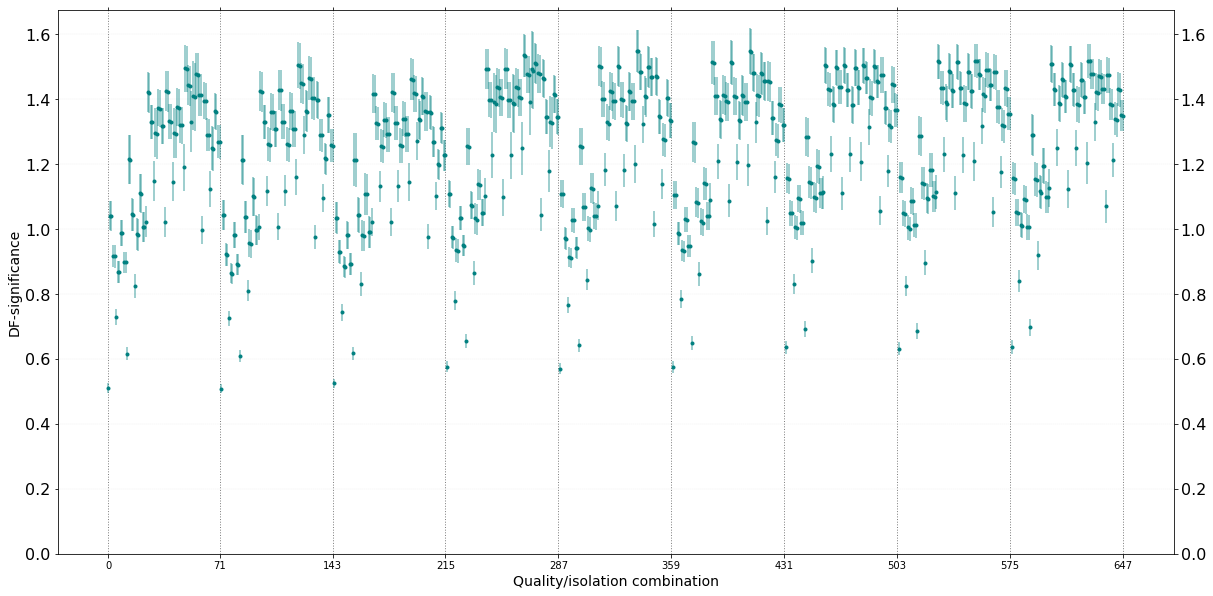

Initial significance:
0.51 ± 0.01

Maximum significance:
1.55 ± 0.06
when
quality for electrons: medium 
quality for muons: medium
isolation for electrons: 4
isolation for muons: 1


In [29]:
x = range( n_qualities*n_iso )

# Uncomment a block:

# title = 'significance'
# y     = W_qual_iso_df['significance']
# y_err  = W_qual_iso_df['significance-err']
# color = 'teal'

# title = 'SF-inZ-significance'
# y     = W_qual_iso_df['SF-inZ-significance']
# y_err  = W_qual_iso_df['SF-inZ-significance-err']
# color = 'teal'

# title = 'SF-noZ-significance'
# y     = W_qual_iso_df['SF-noZ-significance']
# y_err  = W_qual_iso_df['SF-noZ-significance-err']
# color = 'teal'

title = 'DF-significance'
y     = W_qual_iso_df['DF-significance']
y_err  = W_qual_iso_df['DF-significance-err']
color = 'teal'

# title = 'signal'
# y     = W_qual_iso_df['signal']
# y_err  = W_qual_iso_df['signal-err']
# color = 'crimson'

# title = 'SF-inZ-signal'
# y     = W_qual_iso_df['SF-inZ-signal']
# y_err  = W_qual_iso_df['SF-inZ-signal-err']
# color = 'crimson'

# title = 'SF-noZ-signal'
# y     = W_qual_iso_df['SF-noZ-signal']
# y_err  = W_qual_iso_df['SF-noZ-signal-err']
# color = 'crimson'

# title = 'DF-signal'
# y     = W_qual_iso_df['DF-signal']
# y_err  = W_qual_iso_df['DF-signal-err']
# color = 'crimson'

# title = 'background'
# y     = W_qual_iso_df['background']
# y_err  = W_qual_iso_df['background-err']
# color = 'blue'

# title = 'SF-inZ-background'
# y     = W_qual_iso_df['SF-inZ-background']
# y_err  = W_qual_iso_df['SF-inZ-background-err']
# color = 'blue'

# title = 'SF-noZ-background'
# y     = W_qual_iso_df['SF-noZ-background']
# y_err  = W_qual_iso_df['SF-noZ-background-err']
# color = 'blue'

# title = 'DF-background'
# y     = W_qual_iso_df['DF-background']
# y_err  = W_qual_iso_df['DF-background-err']
# color = 'blue'

y = np.array(y)
y_err = np.array(y_err)

plt.figure(figsize=[20,10]) 
plt.plot(x, y, 'o', color=color, markersize=3)
plt.errorbar(x, y, yerr=y_err, 
             fmt=' ', capsize=0, color=color, alpha=0.5)
plt.xlabel("Quality/isolation combination", fontsize=14)
plt.xticks([0, 71, 143, 215, 287, 359, 431, 503, 575, 647], fontsize=10)
plt.ylabel(title, fontsize=14)
# plt.yscale('log')
# plt.ylabel('log({})'.format(title), fontsize=14)
plt.ylim(0)
plt.tick_params(bottom=True, top=True, left=True, right=True)
plt.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=True)
plt.yticks(fontsize=16)

plt.grid(axis="x", color="grey", alpha=1, linewidth=1, linestyle=":")
plt.grid(axis="y", color="grey", alpha=.5, linewidth=.25, linestyle=":")
plt.savefig('plots/Using_W_leptons_{}_{}.pdf'.format(title, identifier))
plt.show()

print('Initial significance:'.format(title))
print("{:.2f} ± {:.2f}".format( y[0], y_err[0] ))
print()

print('Maximum significance:'.format(title))
index_max = np.argmax(y)
print("{:.2f} ± {:.2f}".format(y[index_max], y_err[index_max]))
# print('at index: {}'.format(index_max))
print('when')

counter = 0
for quality in range(n_qualities): # qualities: LL, LM, LT, ML, MM, MT, TL, TM, TT
    for i in range(n_iso_electrons): # isolation for electrons, 0 means no iso
        for j in range(n_iso_muons): # isolation for muons, 0 means no iso
            if (counter == index_max):
                if (quality == 0):
                    print('quality for electrons: loose', '\nquality for muons: loose')
                if (quality == 1):
                    print('quality for electrons: loose', '\nquality for muons: medium')
                if (quality == 2):
                    print('quality for electrons: loose', '\nquality for muons: tight')
                if (quality == 3):
                    print('quality for electrons: medium', '\nquality for muons: loose')
                if (quality == 4):
                    print('quality for electrons: medium', '\nquality for muons: medium')
                if (quality == 5):
                    print('quality for electrons: medium', '\nquality for muons: tight')
                if (quality == 6):
                    print('quality for electrons: tight', '\nquality for muons: loose')
                if (quality == 7):
                    print('quality for electrons: tight', '\nquality for muons: medium')
                if (quality == 8):
                    print('quality for electrons: tight', '\nquality for muons: tight')
                print('isolation for electrons: {}'.format(i))
                print('isolation for muons: {}'.format(j))
            counter += 1


# Isolation on Z leptons

You can load a dataframe from file or do a full event loop which is slow

In [30]:
Z_qual_iso_df = pd.read_csv('csv/Z_qual_iso_df.csv')

#### Event loop (uncomment if want to use)

In [31]:
# Z_qual_iso_df = pd.DataFrame()

# for n, df in zip([0,1],[sig, bkg]):
    
#     if (n == 0):
#         print("--- analyzing the signal")
#     if (n == 1):
#         print("--- analyzing the background")
        
#     y        = np.zeros((3,n_qualities*n_iso)) # for each SR
#     y_err    = np.zeros((3,n_qualities*n_iso)) # for each SR

#     for SR in [0,1,2]:
        
#         print('--- Signal Region = ', SR)
#         counter = -1 # counter will go from 0 to 647
#         sr_df = df[df.SR == SR].copy()
        
#         # Quality loop (LL, LM, LT, ML, MM, MT, TL, TM, TT)
#         for quality in range(n_qualities):
            
#             qual_df = sr_df.copy()
#             # Check quality
#             # LL
#             if (quality == 0): 
#                 pass
#             # LM
#             elif (quality == 1): 
#                 qual_df = qual_df[(abs(qual_df.Zlep1_pid) == 11) | (qual_df.Zlep1_medium == True)] # medium muons 
#                 qual_df = qual_df[(abs(qual_df.Zlep2_pid) == 11) | (qual_df.Zlep2_medium == True)] # medium muons
#             # LT
#             elif (quality == 2): 
#                 qual_df = qual_df[(abs(qual_df.Zlep1_pid) == 11) | (qual_df.Zlep1_tight == True)] # tight muons
#                 qual_df = qual_df[(abs(qual_df.Zlep2_pid) == 11) | (qual_df.Zlep2_tight == True)] # tight muons
#             # ML
#             elif (quality == 3): 
#                 qual_df = qual_df[(abs(qual_df.Zlep1_pid) == 13) | (qual_df.Zlep1_medium == True)] # medium electrons
#                 qual_df = qual_df[(abs(qual_df.Zlep2_pid) == 13) | (qual_df.Zlep2_medium == True)] # medium electrons
#             # MM
#             elif (quality == 4): 
#                 qual_df = qual_df[qual_df.Zlep1_medium == True] # medium all
#                 qual_df = qual_df[qual_df.Zlep2_medium == True] # medium all
#             # MT
#             elif (quality == 5): 
#                 qual_df = qual_df[(abs(qual_df.Zlep1_pid) == 13) | (qual_df.Zlep1_medium == True)] # medium electrons
#                 qual_df = qual_df[(abs(qual_df.Zlep1_pid) == 11) | (qual_df.Zlep1_tight == True)]  # tight muons
#                 qual_df = qual_df[(abs(qual_df.Zlep2_pid) == 13) | (qual_df.Zlep2_medium == True)] # medium electrons
#                 qual_df = qual_df[(abs(qual_df.Zlep2_pid) == 11) | (qual_df.Zlep2_tight == True)]  # tight muons
#             # TL
#             elif (quality == 6): 
#                 qual_df = qual_df[(abs(qual_df.Zlep1_pid) == 13) | (qual_df.Zlep1_tight == True)] # tight electrons
#                 qual_df = qual_df[(abs(qual_df.Zlep2_pid) == 13) | (qual_df.Zlep2_tight == True)] # tight electrons
#             # TM
#             elif (quality == 7):
#                 qual_df = qual_df[(abs(qual_df.Zlep1_pid) == 13) | (qual_df.Zlep1_tight == True)]  # tight electrons
#                 qual_df = qual_df[(abs(qual_df.Zlep1_pid) == 11) | (qual_df.Zlep1_medium == True)] # medium muons 
#                 qual_df = qual_df[(abs(qual_df.Zlep2_pid) == 13) | (qual_df.Zlep2_tight == True)]  # tight electrons
#                 qual_df = qual_df[(abs(qual_df.Zlep2_pid) == 11) | (qual_df.Zlep2_medium == True)] # medium muons
#             # TT
#             elif (quality == 8):
#                 qual_df = qual_df[qual_df.Zlep1_tight == True] # tight all
#                 qual_df = qual_df[qual_df.Zlep2_tight == True] # tight all

#             # Isolation loop for electrons, 0 means no iso
#             for i in range(n_iso_electrons): 
                
#                 iso_e_df = qual_df.copy()
#                 if (i == 0):
#                     pass
#                 else:
#                     iso_e_df = iso_e_df[(abs(iso_e_df.Zlep1_pid) == 13) | (iso_e_df['Zlep1_iso_{}'.format(i)] == True)] # iso_i electrons
#                     iso_e_df = iso_e_df[(abs(iso_e_df.Zlep2_pid) == 13) | (iso_e_df['Zlep2_iso_{}'.format(i)] == True)] # iso_i electrons
                
#                 # Isolation loop for muons, 0 means no iso
#                 for j in range(n_iso_muons):
                    
#                     iso_mu_df = iso_e_df.copy()
#                     if (j == 0):
#                         pass
#                     else:
#                         iso_mu_df = iso_mu_df[(abs(iso_mu_df.Zlep1_pid) == 11) | (iso_mu_df['Zlep1_iso_{}'.format(j)] == True)] # iso_j muons
#                         iso_mu_df = iso_mu_df[(abs(iso_mu_df.Zlep2_pid) == 11) | (iso_mu_df['Zlep2_iso_{}'.format(j)] == True)] # iso_j muons
                        
#                     counter += 1
#                     print('counter = ', counter)

#                     y[SR][counter]     = sum(iso_mu_df['wgt'])
#                     y_err[SR][counter] = sum(iso_mu_df['wgt']**2)

#     y_err[0] = np.sqrt(y_err[0])
#     y_err[1] = np.sqrt(y_err[1])
#     y_err[2] = np.sqrt(y_err[2])

#     # Saving information:
#     if (n == 0):
#         Z_qual_iso_df['SF-inZ-signal']     = pd.Series(y[0])
#         Z_qual_iso_df['SF-inZ-signal-err'] = pd.Series(y_err[0])
#         Z_qual_iso_df['SF-noZ-signal']     = pd.Series(y[1])
#         Z_qual_iso_df['SF-noZ-signal-err'] = pd.Series(y_err[1])
#         Z_qual_iso_df['DF-signal']         = pd.Series(y[2])
#         Z_qual_iso_df['DF-signal-err']     = pd.Series(y_err[2])
#         Z_qual_iso_df['signal']            = pd.Series(y[0]+y[1]+y[2])
#         Z_qual_iso_df['signal-err']        = pd.Series(np.sqrt(y_err[0]**2 + y_err[1]**2 + y_err[2]**2))
        
#     if (n == 1):
#         Z_qual_iso_df['SF-inZ-background']     = pd.Series(y[0])
#         Z_qual_iso_df['SF-inZ-background-err'] = pd.Series(y_err[0])
#         Z_qual_iso_df['SF-noZ-background']     = pd.Series(y[1])
#         Z_qual_iso_df['SF-noZ-background-err'] = pd.Series(y_err[1])
#         Z_qual_iso_df['DF-background']         = pd.Series(y[2])
#         Z_qual_iso_df['DF-background-err']     = pd.Series(y_err[2])
#         Z_qual_iso_df['background']            = pd.Series(y[0]+y[1]+y[2])
#         Z_qual_iso_df['background-err']        = pd.Series(np.sqrt(y_err[0]**2 + y_err[1]**2 + y_err[2]**2))
        
        
# # Calculating the significances
# print("Calculating the significances")
# significances = [[],[],[],[]] 
# errors = [[],[],[],[]]

# for choice in Z_qual_iso_df.index:

#     # SF-inZ
#     significance, error = significance_and_error(Z_qual_iso_df.at[choice,'SF-inZ-signal'], \
#                                                  Z_qual_iso_df.at[choice,'SF-inZ-signal-err'], \
#                                                  Z_qual_iso_df.at[choice,'SF-inZ-background'], \
#                                                  Z_qual_iso_df.at[choice,'SF-inZ-background-err'])
#     significances[0].append(significance)
#     errors[0].append(error)
#     # SF-noZ
#     significance, error = significance_and_error(Z_qual_iso_df.at[choice,'SF-noZ-signal'], \
#                                                  Z_qual_iso_df.at[choice,'SF-noZ-signal-err'], \
#                                                  Z_qual_iso_df.at[choice,'SF-noZ-background'], \
#                                                  Z_qual_iso_df.at[choice,'SF-noZ-background-err'])
#     significances[1].append(significance)
#     errors[1].append(error)
#     # DF
#     significance, error = significance_and_error(Z_qual_iso_df.at[choice,'DF-signal'], \
#                                                  Z_qual_iso_df.at[choice,'DF-signal-err'], \
#                                                  Z_qual_iso_df.at[choice,'DF-background'], \
#                                                  Z_qual_iso_df.at[choice,'DF-background-err'])
#     significances[2].append(significance)
#     errors[2].append(error)
#     # Quadrature
#     significance, error = add_in_quadrature_3((significances[0][-1], errors[0][-1]), 
#                                               (significances[1][-1], errors[1][-1]),
#                                               (significances[2][-1], errors[2][-1]),)
#     significances[3].append(significance)
#     errors[3].append(error)
    
# Z_qual_iso_df['SF-inZ-significance']     = pd.Series(significances[0])
# Z_qual_iso_df['SF-inZ-significance-err'] = pd.Series(errors[0])
# Z_qual_iso_df['SF-noZ-significance']     = pd.Series(significances[1])
# Z_qual_iso_df['SF-noZ-significance-err'] = pd.Series(errors[1])
# Z_qual_iso_df['DF-significance']         = pd.Series(significances[2])
# Z_qual_iso_df['DF-significance-err']     = pd.Series(errors[2])
# Z_qual_iso_df['significance']            = pd.Series(significances[3])
# Z_qual_iso_df['significance-err']        = pd.Series(errors[3])
# print("--- Done!")

In [32]:
# Z_qual_iso_df.to_csv('Z_qual_iso_df.csv')

Plot any quantity vs quality/isolation

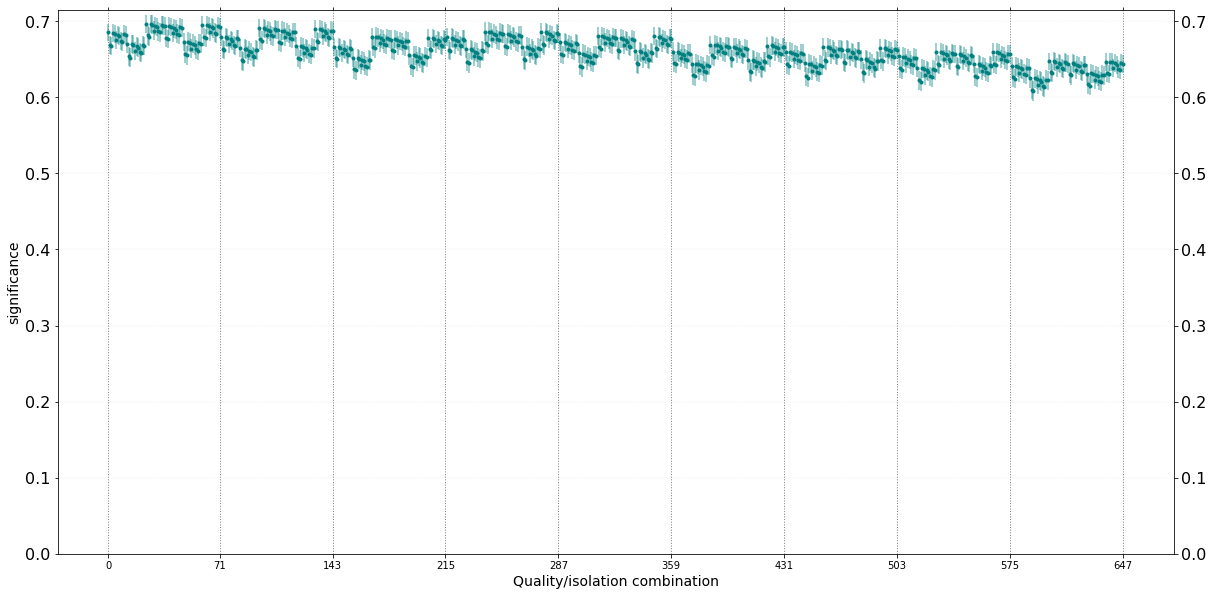

Loosest significance:
0.69 ± 0.01

Maximum significance:
0.70 ± 0.01
at value: 24

quality for electrons: loose 
quality for muons: loose
isolation for electrons: 2
isolation for muons: 0


In [34]:
x = range( n_qualities*n_iso )

# Uncomment a block:

title = 'significance'
y     = Z_qual_iso_df['significance']
y_err  = Z_qual_iso_df['significance-err']
color = 'teal'

# title = 'SF-inZ-significance'
# y     = Z_qual_iso_df['SF-inZ-significance']
# y_err  = Z_qual_iso_df['SF-inZ-significance-err']
# color = 'teal'

# title = 'SF-noZ-significance'
# y     = Z_qual_iso_df['SF-noZ-significance']
# y_err  = Z_qual_iso_df['SF-noZ-significance-err']
# color = 'teal'

# title = 'DF-significance'
# y     = Z_qual_iso_df['DF-significance']
# y_err  = Z_qual_iso_df['DF-significance-err']
# color = 'teal'

# title = 'signal'
# y     = Z_qual_iso_df['signal']
# y_err  = Z_qual_iso_df['signal-err']
# color = 'crimson'

# title = 'SF-inZ-signal'
# y     = Z_qual_iso_df['SF-inZ-signal']
# y_err  = Z_qual_iso_df['SF-inZ-signal-err']
# color = 'crimson'

# title = 'SF-noZ-signal'
# y     = Z_qual_iso_df['SF-noZ-signal']
# y_err  = Z_qual_iso_df['SF-noZ-signal-err']
# color = 'crimson'

# title = 'DF-signal'
# y     = Z_qual_iso_df['DF-signal']
# y_err  = Z_qual_iso_df['DF-signal-err']
# color = 'crimson'

# title = 'background'
# y     = Z_qual_iso_df['background']
# y_err  = Z_qual_iso_df['background-err']
# color = 'blue'

# title = 'SF-inZ-background'
# y     = Z_qual_iso_df['SF-inZ-background']
# y_err  = Z_qual_iso_df['SF-inZ-background-err']
# color = 'blue'

# title = 'SF-noZ-background'
# y     = Z_qual_iso_df['SF-noZ-background']
# y_err  = Z_qual_iso_df['SF-noZ-background-err']
# color = 'blue'

# title = 'DF-background'
# y     = Z_qual_iso_df['DF-background']
# y_err  = Z_qual_iso_df['DF-background-err']
# color = 'blue'

y = np.array(y)
y_err = np.array(y_err)

plt.figure(figsize=[20,10]) 
plt.plot(x, y, 'o', color=color, markersize=3)
plt.errorbar(x, y, yerr=y_err, 
             fmt=' ', capsize=0, color=color, alpha=0.5)
plt.xlabel("Quality/isolation combination", fontsize=14)
plt.xticks([0, 71, 143, 215, 287, 359, 431, 503, 575, 647], fontsize=10)
plt.ylabel(title, fontsize=14)
# plt.yscale('log')
# plt.ylabel('log({})'.format(title), fontsize=14)
# plt.ylim([0,50])
plt.ylim(0)
plt.tick_params(bottom=True, top=True, left=True, right=True)
plt.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=True)
plt.yticks(fontsize=16)

plt.grid(axis="x", color="grey", alpha=1, linewidth=1, linestyle=":")
plt.grid(axis="y", color="grey", alpha=.5, linewidth=.25, linestyle=":")
plt.savefig('plots/Using_Z_leptons_{}_{}.pdf'.format(title, identifier))
plt.show()

print('Loosest significance:'.format(title))
print("{:.2f} ± {:.2f}".format( y[0], y_err[0] ))
print()

print('Maximum significance:'.format(title))
index_max = np.argmax(y)
print("{:.2f} ± {:.2f}".format(y[index_max], y_err[index_max]))
print('at value: {}'.format(index_max))
print()

counter = 0
for quality in range(n_qualities): # qualities: LL, LM, LT, ML, MM, MT, TL, TM, TT
    for i in range(n_iso_electrons): # isolation for electrons, 0 means no iso
        for j in range(n_iso_muons): # isolation for muons, 0 means no iso
            if (counter == index_max):
                if (quality == 0):
                    print('quality for electrons: loose', '\nquality for muons: loose')
                if (quality == 1):
                    print('quality for electrons: loose', '\nquality for muons: medium')
                if (quality == 2):
                    print('quality for electrons: loose', '\nquality for muons: tight')
                if (quality == 3):
                    print('quality for electrons: medium', '\nquality for muons: loose')
                if (quality == 4):
                    print('quality for electrons: medium', '\nquality for muons: medium')
                if (quality == 5):
                    print('quality for electrons: medium', '\nquality for muons: tight')
                if (quality == 6):
                    print('quality for electrons: tight', '\nquality for muons: loose')
                if (quality == 7):
                    print('quality for electrons: tight', '\nquality for muons: medium')
                if (quality == 8):
                    print('quality for electrons: tight', '\nquality for muons: tight')
                print('isolation for electrons: {}'.format(i))
                print('isolation for muons: {}'.format(j))
            counter += 1

# Isolation on all 4 leptons

You can load a dataframe from file or do a full event loop which is slow

In [36]:
ALL_qual_iso_df = pd.read_csv('csv/ALL_qual_iso_df.csv')

#### Event loop (uncomment if want to use)

In [37]:
# ALL_qual_iso_df = pd.DataFrame()

# for n, df in zip([0,1],[sig, bkg]):
    
#     if (n == 0):
#         print("--- analyzing the signal")
#     if (n == 1):
#         print("--- analyzing the background")
        
#     y        = np.zeros((3,n_qualities*n_iso)) # for each SR
#     y_err    = np.zeros((3,n_qualities*n_iso)) # for each SR

#     for SR in [0,1,2]:
        
#         print('--- Signal Region = ', SR)
#         counter = -1 # counter will go from 0 to 647
#         sr_df = df[df.SR == SR].copy()
        
#         # Quality loop (LL, LM, LT, ML, MM, MT, TL, TM, TT)
#         for quality in range(n_qualities):
            
#             qual_df = sr_df.copy()
#             # Check quality
#             # LL
#             if (quality == 0): 
#                 pass
#             # LM
#             elif (quality == 1): 
#                 qual_df = qual_df[(abs(qual_df.Zlep1_pid) == 11) | (qual_df.Zlep1_medium == True)] # medium muons 
#                 qual_df = qual_df[(abs(qual_df.Zlep2_pid) == 11) | (qual_df.Zlep2_medium == True)] # medium muons
#                 qual_df = qual_df[(abs(qual_df.Wlep1_pid) == 11) | (qual_df.Wlep1_medium == True)] # medium muons 
#                 qual_df = qual_df[(abs(qual_df.Wlep2_pid) == 11) | (qual_df.Wlep2_medium == True)] # medium muons
#             # LT
#             elif (quality == 2): 
#                 qual_df = qual_df[(abs(qual_df.Zlep1_pid) == 11) | (qual_df.Zlep1_tight == True)] # tight muons
#                 qual_df = qual_df[(abs(qual_df.Zlep2_pid) == 11) | (qual_df.Zlep2_tight == True)] # tight muons
#                 qual_df = qual_df[(abs(qual_df.Wlep1_pid) == 11) | (qual_df.Wlep1_tight == True)] # tight muons
#                 qual_df = qual_df[(abs(qual_df.Wlep2_pid) == 11) | (qual_df.Wlep2_tight == True)] # tight muons
#             # ML
#             elif (quality == 3): 
#                 qual_df = qual_df[(abs(qual_df.Zlep1_pid) == 13) | (qual_df.Zlep1_medium == True)] # medium electrons
#                 qual_df = qual_df[(abs(qual_df.Zlep2_pid) == 13) | (qual_df.Zlep2_medium == True)] # medium electrons
#                 qual_df = qual_df[(abs(qual_df.Wlep1_pid) == 13) | (qual_df.Wlep1_medium == True)] # medium electrons
#                 qual_df = qual_df[(abs(qual_df.Wlep2_pid) == 13) | (qual_df.Wlep2_medium == True)] # medium electrons
#             # MM
#             elif (quality == 4): 
#                 qual_df = qual_df[qual_df.Zlep1_medium == True] # medium all
#                 qual_df = qual_df[qual_df.Zlep2_medium == True] # medium all
#                 qual_df = qual_df[qual_df.Wlep1_medium == True] # medium all
#                 qual_df = qual_df[qual_df.Wlep2_medium == True] # medium all
#             # MT
#             elif (quality == 5): 
#                 qual_df = qual_df[(abs(qual_df.Zlep1_pid) == 13) | (qual_df.Zlep1_medium == True)] # medium electrons
#                 qual_df = qual_df[(abs(qual_df.Zlep1_pid) == 11) | (qual_df.Zlep1_tight == True)]  # tight muons
#                 qual_df = qual_df[(abs(qual_df.Zlep2_pid) == 13) | (qual_df.Zlep2_medium == True)] # medium electrons
#                 qual_df = qual_df[(abs(qual_df.Zlep2_pid) == 11) | (qual_df.Zlep2_tight == True)]  # tight muons
#                 qual_df = qual_df[(abs(qual_df.Wlep1_pid) == 13) | (qual_df.Wlep1_medium == True)] # medium electrons
#                 qual_df = qual_df[(abs(qual_df.Wlep1_pid) == 11) | (qual_df.Wlep1_tight == True)]  # tight muons
#                 qual_df = qual_df[(abs(qual_df.Wlep2_pid) == 13) | (qual_df.Wlep2_medium == True)] # medium electrons
#                 qual_df = qual_df[(abs(qual_df.Wlep2_pid) == 11) | (qual_df.Wlep2_tight == True)]  # tight muons
#             # TL
#             elif (quality == 6): 
#                 qual_df = qual_df[(abs(qual_df.Zlep1_pid) == 13) | (qual_df.Zlep1_tight == True)] # tight electrons
#                 qual_df = qual_df[(abs(qual_df.Zlep2_pid) == 13) | (qual_df.Zlep2_tight == True)] # tight electrons
#                 qual_df = qual_df[(abs(qual_df.Wlep1_pid) == 13) | (qual_df.Wlep1_tight == True)] # tight electrons
#                 qual_df = qual_df[(abs(qual_df.Wlep2_pid) == 13) | (qual_df.Wlep2_tight == True)] # tight electrons
#             # TM
#             elif (quality == 7):
#                 qual_df = qual_df[(abs(qual_df.Zlep1_pid) == 13) | (qual_df.Zlep1_tight == True)]  # tight electrons
#                 qual_df = qual_df[(abs(qual_df.Zlep1_pid) == 11) | (qual_df.Zlep1_medium == True)] # medium muons 
#                 qual_df = qual_df[(abs(qual_df.Zlep2_pid) == 13) | (qual_df.Zlep2_tight == True)]  # tight electrons
#                 qual_df = qual_df[(abs(qual_df.Zlep2_pid) == 11) | (qual_df.Zlep2_medium == True)] # medium muons
#                 qual_df = qual_df[(abs(qual_df.Wlep1_pid) == 13) | (qual_df.Wlep1_tight == True)]  # tight electrons
#                 qual_df = qual_df[(abs(qual_df.Wlep1_pid) == 11) | (qual_df.Wlep1_medium == True)] # medium muons 
#                 qual_df = qual_df[(abs(qual_df.Wlep2_pid) == 13) | (qual_df.Wlep2_tight == True)]  # tight electrons
#                 qual_df = qual_df[(abs(qual_df.Wlep2_pid) == 11) | (qual_df.Wlep2_medium == True)] # medium muons
#             # TT
#             elif (quality == 8):
#                 qual_df = qual_df[qual_df.Zlep1_tight == True] # tight all
#                 qual_df = qual_df[qual_df.Zlep2_tight == True] # tight all
#                 qual_df = qual_df[qual_df.Wlep1_tight == True] # tight all
#                 qual_df = qual_df[qual_df.Wlep2_tight == True] # tight all

#             # Isolation loop for electrons, 0 means no iso
#             for i in range(n_iso_electrons): 
                
#                 iso_e_df = qual_df.copy()
#                 if (i == 0):
#                     pass
#                 else:
#                     iso_e_df = iso_e_df[(abs(iso_e_df.Zlep1_pid) == 13) | (iso_e_df['Zlep1_iso_{}'.format(i)] == True)] # iso_i electrons
#                     iso_e_df = iso_e_df[(abs(iso_e_df.Zlep2_pid) == 13) | (iso_e_df['Zlep2_iso_{}'.format(i)] == True)] # iso_i electrons
#                     iso_e_df = iso_e_df[(abs(iso_e_df.Wlep1_pid) == 13) | (iso_e_df['Wlep1_iso_{}'.format(i)] == True)] # iso_i electrons
#                     iso_e_df = iso_e_df[(abs(iso_e_df.Wlep2_pid) == 13) | (iso_e_df['Wlep2_iso_{}'.format(i)] == True)] # iso_i electrons
                
#                 # Isolation loop for muons, 0 means no iso
#                 for j in range(n_iso_muons):
                    
#                     iso_mu_df = iso_e_df.copy()
#                     if (j == 0):
#                         pass
#                     else:
#                         iso_mu_df = iso_mu_df[(abs(iso_mu_df.Zlep1_pid) == 11) | (iso_mu_df['Zlep1_iso_{}'.format(j)] == True)] # iso_j muons
#                         iso_mu_df = iso_mu_df[(abs(iso_mu_df.Zlep2_pid) == 11) | (iso_mu_df['Zlep2_iso_{}'.format(j)] == True)] # iso_j muons
#                         iso_mu_df = iso_mu_df[(abs(iso_mu_df.Wlep1_pid) == 11) | (iso_mu_df['Wlep1_iso_{}'.format(j)] == True)] # iso_j muons
#                         iso_mu_df = iso_mu_df[(abs(iso_mu_df.Wlep2_pid) == 11) | (iso_mu_df['Wlep2_iso_{}'.format(j)] == True)] # iso_j muons
                        
#                     counter += 1
#                     print('counter = ', counter)

#                     y[SR][counter]     = sum(iso_mu_df['wgt'])
#                     y_err[SR][counter] = sum(iso_mu_df['wgt']**2)

#     y_err[0] = np.sqrt(y_err[0])
#     y_err[1] = np.sqrt(y_err[1])
#     y_err[2] = np.sqrt(y_err[2])

#     # Saving information:
#     if (n == 0):
#         ALL_qual_iso_df['SF-inZ-signal']     = pd.Series(y[0])
#         ALL_qual_iso_df['SF-inZ-signal-err'] = pd.Series(y_err[0])
#         ALL_qual_iso_df['SF-noZ-signal']     = pd.Series(y[1])
#         ALL_qual_iso_df['SF-noZ-signal-err'] = pd.Series(y_err[1])
#         ALL_qual_iso_df['DF-signal']         = pd.Series(y[2])
#         ALL_qual_iso_df['DF-signal-err']     = pd.Series(y_err[2])
#         ALL_qual_iso_df['signal']            = pd.Series(y[0]+y[1]+y[2])
#         ALL_qual_iso_df['signal-err']        = pd.Series(np.sqrt(y_err[0]**2 + y_err[1]**2 + y_err[2]**2))
        
#     if (n == 1):
#         ALL_qual_iso_df['SF-inZ-background']     = pd.Series(y[0])
#         ALL_qual_iso_df['SF-inZ-background-err'] = pd.Series(y_err[0])
#         ALL_qual_iso_df['SF-noZ-background']     = pd.Series(y[1])
#         ALL_qual_iso_df['SF-noZ-background-err'] = pd.Series(y_err[1])
#         ALL_qual_iso_df['DF-background']         = pd.Series(y[2])
#         ALL_qual_iso_df['DF-background-err']     = pd.Series(y_err[2])
#         ALL_qual_iso_df['background']            = pd.Series(y[0]+y[1]+y[2])
#         ALL_qual_iso_df['background-err']        = pd.Series(np.sqrt(y_err[0]**2 + y_err[1]**2 + y_err[2]**2))
        
        
# # Calculating the significances
# print("Calculating the significances")
# significances = [[],[],[],[]] 
# errors = [[],[],[],[]]

# for choice in ALL_qual_iso_df.index:

#     # SF-inZ
#     significance, error = significance_and_error(ALL_qual_iso_df.at[choice,'SF-inZ-signal'], \
#                                                  ALL_qual_iso_df.at[choice,'SF-inZ-signal-err'], \
#                                                  ALL_qual_iso_df.at[choice,'SF-inZ-background'], \
#                                                  ALL_qual_iso_df.at[choice,'SF-inZ-background-err'])
#     significances[0].append(significance)
#     errors[0].append(error)
#     # SF-noZ
#     significance, error = significance_and_error(ALL_qual_iso_df.at[choice,'SF-noZ-signal'], \
#                                                  ALL_qual_iso_df.at[choice,'SF-noZ-signal-err'], \
#                                                  ALL_qual_iso_df.at[choice,'SF-noZ-background'], \
#                                                  ALL_qual_iso_df.at[choice,'SF-noZ-background-err'])
#     significances[1].append(significance)
#     errors[1].append(error)
#     # DF
#     significance, error = significance_and_error(ALL_qual_iso_df.at[choice,'DF-signal'], \
#                                                  ALL_qual_iso_df.at[choice,'DF-signal-err'], \
#                                                  ALL_qual_iso_df.at[choice,'DF-background'], \
#                                                  ALL_qual_iso_df.at[choice,'DF-background-err'])
#     significances[2].append(significance)
#     errors[2].append(error)
#     # Quadrature
#     significance, error = add_in_quadrature_3((significances[0][-1], errors[0][-1]), 
#                                               (significances[1][-1], errors[1][-1]),
#                                               (significances[2][-1], errors[2][-1]),)
#     significances[3].append(significance)
#     errors[3].append(error)
    
# ALL_qual_iso_df['SF-inZ-significance']     = pd.Series(significances[0])
# ALL_qual_iso_df['SF-inZ-significance-err'] = pd.Series(errors[0])
# ALL_qual_iso_df['SF-noZ-significance']     = pd.Series(significances[1])
# ALL_qual_iso_df['SF-noZ-significance-err'] = pd.Series(errors[1])
# ALL_qual_iso_df['DF-significance']         = pd.Series(significances[2])
# ALL_qual_iso_df['DF-significance-err']     = pd.Series(errors[2])
# ALL_qual_iso_df['significance']            = pd.Series(significances[3])
# ALL_qual_iso_df['significance-err']        = pd.Series(errors[3])
# print("--- Done!")

In [38]:
# ALL_qual_iso_df.to_csv('ALL_qual_iso_df.csv')

Plot any quantity vs quality/isolation

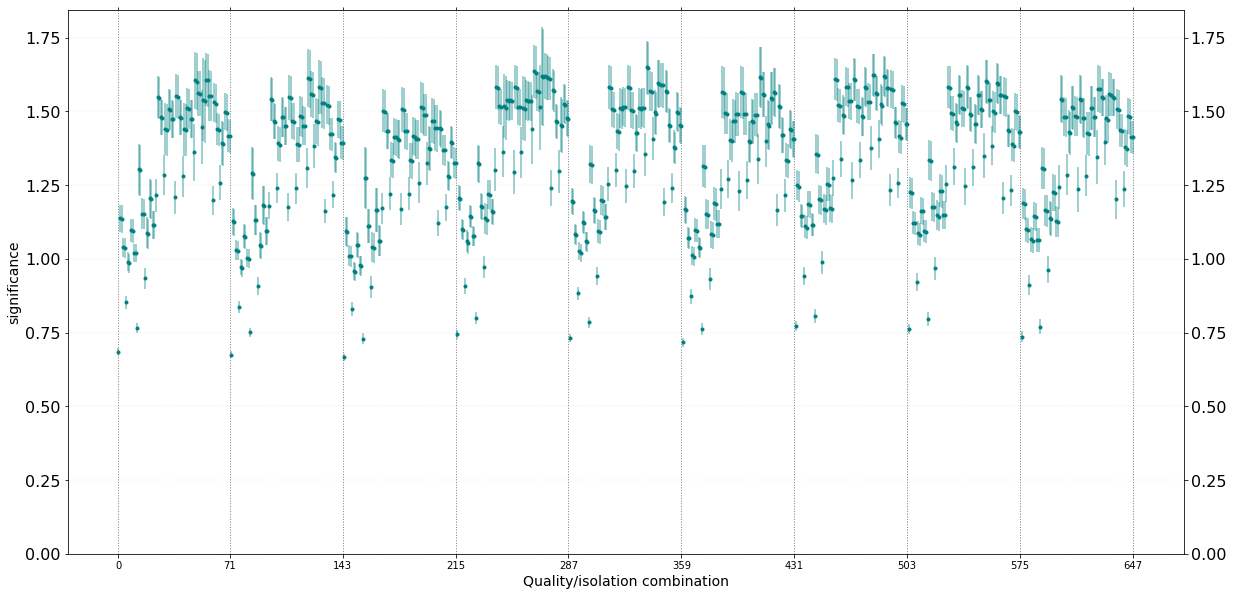

Loosest significance:
0.69 ± 0.01

Maximum significance:
1.65 ± 0.09
at value: 337

quality for electrons: medium 
quality for muons: medium
isolation for electrons: 4
isolation for muons: 1


In [39]:
x = range( n_qualities*n_iso )

# Uncomment a block:

title = 'significance'
y     = ALL_qual_iso_df['significance']
y_err  = ALL_qual_iso_df['significance-err']
color = 'teal'

# title = 'SF-inZ-significance'
# y     = ALL_qual_iso_df['SF-inZ-significance']
# y_err  = ALL_qual_iso_df['SF-inZ-significance-err']
# color = 'teal'

# title = 'SF-noZ-significance'
# y     = ALL_qual_iso_df['SF-noZ-significance']
# y_err  = ALL_qual_iso_df['SF-noZ-significance-err']
# color = 'teal'

# title = 'DF-significance'
# y     = ALL_qual_iso_df['DF-significance']
# y_err  = ALL_qual_iso_df['DF-significance-err']
# color = 'teal'

# title = 'signal'
# y     = ALL_qual_iso_df['signal']
# y_err  = ALL_qual_iso_df['signal-err']
# color = 'crimson'

# title = 'SF-inZ-signal'
# y     = ALL_qual_iso_df['SF-inZ-signal']
# y_err  = ALL_qual_iso_df['SF-inZ-signal-err']
# color = 'crimson'

# title = 'SF-noZ-signal'
# y     = ALL_qual_iso_df['SF-noZ-signal']
# y_err  = ALL_qual_iso_df['SF-noZ-signal-err']
# color = 'crimson'

# title = 'DF-signal'
# y     = ALL_qual_iso_df['DF-signal']
# y_err  = ALL_qual_iso_df['DF-signal-err']
# color = 'crimson'

# title = 'background'
# y     = ALL_qual_iso_df['background']
# y_err  = ALL_qual_iso_df['background-err']
# color = 'blue'

# title = 'SF-inZ-background'
# y     = ALL_qual_iso_df['SF-inZ-background']
# y_err  = ALL_qual_iso_df['SF-inZ-background-err']
# color = 'blue'

# title = 'SF-noZ-background'
# y     = ALL_qual_iso_df['SF-noZ-background']
# y_err  = ALL_qual_iso_df['SF-noZ-background-err']
# color = 'blue'

# title = 'DF-background'
# y     = ALL_qual_iso_df['DF-background']
# y_err  = ALL_qual_iso_df['DF-background-err']
# color = 'blue'


plt.figure(figsize=[20,10]) 
plt.plot(x, y, 'o', color=color, markersize=3)
plt.errorbar(x, y, yerr=y_err, 
             fmt=' ', capsize=0, color=color, alpha=0.5)
plt.xlabel("Quality/isolation combination", fontsize=14)
plt.xticks([0, 71, 143, 215, 287, 359, 431, 503, 575, 647], fontsize=10)
plt.ylabel(title, fontsize=14)
# plt.yscale('log')
# plt.ylabel('log({})'.format(title), fontsize=14)
# plt.ylim([0,50])
plt.ylim(0)
plt.tick_params(bottom=True, top=True, left=True, right=True)
plt.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=True)
plt.yticks(fontsize=16)

plt.grid(axis="x", color="grey", alpha=1, linewidth=1, linestyle=":")
plt.grid(axis="y", color="grey", alpha=.5, linewidth=.25, linestyle=":")
plt.savefig('plots/Using_all_leptons_{}_{}.pdf'.format(title, identifier))
plt.show()

print('Loosest significance:'.format(title))
print("{:.2f} ± {:.2f}".format( y[0], y_err[0] ))
print()

print('Maximum significance:'.format(title))
index_max = np.argmax(y)
print("{:.2f} ± {:.2f}".format(y[index_max], y_err[index_max]))
print('at value: {}'.format(index_max))
print()

counter = 0
for quality in range(n_qualities): # qualities: LL, LM, LT, ML, MM, MT, TL, TM, TT
    for i in range(n_iso_electrons): # isolation for electrons, 0 means no iso
        for j in range(n_iso_muons): # isolation for muons, 0 means no iso
            if (counter == index_max):
                if (quality == 0):
                    print('quality for electrons: loose', '\nquality for muons: loose')
                if (quality == 1):
                    print('quality for electrons: loose', '\nquality for muons: medium')
                if (quality == 2):
                    print('quality for electrons: loose', '\nquality for muons: tight')
                if (quality == 3):
                    print('quality for electrons: medium', '\nquality for muons: loose')
                if (quality == 4):
                    print('quality for electrons: medium', '\nquality for muons: medium')
                if (quality == 5):
                    print('quality for electrons: medium', '\nquality for muons: tight')
                if (quality == 6):
                    print('quality for electrons: tight', '\nquality for muons: loose')
                if (quality == 7):
                    print('quality for electrons: tight', '\nquality for muons: medium')
                if (quality == 8):
                    print('quality for electrons: tight', '\nquality for muons: tight')
                print('isolation for electrons: {}'.format(i))
                print('isolation for muons: {}'.format(j))
            counter += 1

# Trying quality/isolation on the 4th lepton only:

You can load a dataframe from file or do a full event loop which is slow

In [40]:
lep4_qual_iso_df = pd.read_csv('csv/lep4_qual_iso_df.csv')

In [23]:
# lep4_qual_iso_df = pd.DataFrame()

# for n, df in zip([0,1],[sig, bkg]):
    
#     if (n == 0):
#         print("--- analyzing the signal")
#     if (n == 1):
#         print("--- analyzing the background")
        
#     y        = np.zeros((3,n_qualities*n_iso)) # for each SR
#     y_err    = np.zeros((3,n_qualities*n_iso)) # for each SR

#     for SR in [0,1,2]:
        
#         print('--- Signal Region = ', SR)
#         counter = -1 # counter will go from 0 to 647
#         sr_df = df[df.SR == SR].copy()
        
#         # Quality loop (LL, LM, LT, ML, MM, MT, TL, TM, TT)
#         for quality in range(n_qualities):
            
#             qual_df = sr_df.copy()
#             # Check quality
#             # LL
#             if (quality == 0): 
#                 pass
#             # LM
#             elif (quality == 1): 
#                 qual_df = qual_df[(abs(qual_df.lep4_pid) == 11) | (qual_df.lep4_medium == True)] # medium muons 
#             # LT
#             elif (quality == 2): 
#                 qual_df = qual_df[(abs(qual_df.lep4_pid) == 11) | (qual_df.lep4_tight == True)] # tight muons
#             # ML
#             elif (quality == 3): 
#                 qual_df = qual_df[(abs(qual_df.lep4_pid) == 13) | (qual_df.lep4_medium == True)] # medium electrons
#             # MM
#             elif (quality == 4): 
#                 qual_df = qual_df[qual_df.lep4_medium == True] # medium all
#             # MT
#             elif (quality == 5): 
#                 qual_df = qual_df[(abs(qual_df.lep4_pid) == 13) | (qual_df.lep4_medium == True)] # medium electrons
#                 qual_df = qual_df[(abs(qual_df.lep4_pid) == 11) | (qual_df.lep4_tight == True)]  # tight muons
#             # TL
#             elif (quality == 6): 
#                 qual_df = qual_df[(abs(qual_df.lep4_pid) == 13) | (qual_df.lep4_tight == True)] # tight electrons
#             # TM
#             elif (quality == 7):
#                 qual_df = qual_df[(abs(qual_df.lep4_pid) == 13) | (qual_df.lep4_tight == True)]  # tight electrons
#                 qual_df = qual_df[(abs(qual_df.lep4_pid) == 11) | (qual_df.lep4_medium == True)] # medium muons 
#             # TT
#             elif (quality == 8):
#                 qual_df = qual_df[qual_df.lep4_tight == True] # tight all

#             # Isolation loop for electrons, 0 means no iso
#             for i in range(n_iso_electrons): 
                
#                 iso_e_df = qual_df.copy()
#                 if (i == 0):
#                     pass
#                 else:
#                     iso_e_df = iso_e_df[(abs(iso_e_df.lep4_pid) == 13) | (iso_e_df['lep4_iso_{}'.format(i)] == True)] # iso_i electrons
                
#                 # Isolation loop for muons, 0 means no iso
#                 for j in range(n_iso_muons):
                    
#                     iso_mu_df = iso_e_df.copy()
#                     if (j == 0):
#                         pass
#                     else:
#                         iso_mu_df = iso_mu_df[(abs(iso_mu_df.lep4_pid) == 11) | (iso_mu_df['lep4_iso_{}'.format(j)] == True)] # iso_j muons
                        
#                     counter += 1
#                     print('counter = ', counter)

#                     y[SR][counter]     = sum(iso_mu_df['wgt'])
#                     y_err[SR][counter] = sum(iso_mu_df['wgt']**2)

#     y_err[0] = np.sqrt(y_err[0])
#     y_err[1] = np.sqrt(y_err[1])
#     y_err[2] = np.sqrt(y_err[2])

#     # Saving information:
#     if (n == 0):
#         lep4_qual_iso_df['SF-inZ-signal']     = pd.Series(y[0])
#         lep4_qual_iso_df['SF-inZ-signal-err'] = pd.Series(y_err[0])
#         lep4_qual_iso_df['SF-noZ-signal']     = pd.Series(y[1])
#         lep4_qual_iso_df['SF-noZ-signal-err'] = pd.Series(y_err[1])
#         lep4_qual_iso_df['DF-signal']         = pd.Series(y[2])
#         lep4_qual_iso_df['DF-signal-err']     = pd.Series(y_err[2])
#         lep4_qual_iso_df['signal']            = pd.Series(y[0]+y[1]+y[2])
#         lep4_qual_iso_df['signal-err']        = pd.Series(np.sqrt(y_err[0]**2 + y_err[1]**2 + y_err[2]**2))
        
#     if (n == 1):
#         lep4_qual_iso_df['SF-inZ-background']     = pd.Series(y[0])
#         lep4_qual_iso_df['SF-inZ-background-err'] = pd.Series(y_err[0])
#         lep4_qual_iso_df['SF-noZ-background']     = pd.Series(y[1])
#         lep4_qual_iso_df['SF-noZ-background-err'] = pd.Series(y_err[1])
#         lep4_qual_iso_df['DF-background']         = pd.Series(y[2])
#         lep4_qual_iso_df['DF-background-err']     = pd.Series(y_err[2])
#         lep4_qual_iso_df['background']            = pd.Series(y[0]+y[1]+y[2])
#         lep4_qual_iso_df['background-err']        = pd.Series(np.sqrt(y_err[0]**2 + y_err[1]**2 + y_err[2]**2))
        
        
# # Calculating the significances
# print("Calculating the significances")
# significances = [[],[],[],[]] 
# errors = [[],[],[],[]]

# for choice in lep4_qual_iso_df.index:

#     # SF-inZ
#     significance, error = significance_and_error(lep4_qual_iso_df.at[choice,'SF-inZ-signal'], \
#                                                  lep4_qual_iso_df.at[choice,'SF-inZ-signal-err'], \
#                                                  lep4_qual_iso_df.at[choice,'SF-inZ-background'], \
#                                                  lep4_qual_iso_df.at[choice,'SF-inZ-background-err'])
#     significances[0].append(significance)
#     errors[0].append(error)
#     # SF-noZ
#     significance, error = significance_and_error(lep4_qual_iso_df.at[choice,'SF-noZ-signal'], \
#                                                  lep4_qual_iso_df.at[choice,'SF-noZ-signal-err'], \
#                                                  lep4_qual_iso_df.at[choice,'SF-noZ-background'], \
#                                                  lep4_qual_iso_df.at[choice,'SF-noZ-background-err'])
#     significances[1].append(significance)
#     errors[1].append(error)
#     # DF
#     significance, error = significance_and_error(lep4_qual_iso_df.at[choice,'DF-signal'], \
#                                                  lep4_qual_iso_df.at[choice,'DF-signal-err'], \
#                                                  lep4_qual_iso_df.at[choice,'DF-background'], \
#                                                  lep4_qual_iso_df.at[choice,'DF-background-err'])
#     significances[2].append(significance)
#     errors[2].append(error)
#     # Quadrature
#     significance, error = add_in_quadrature_3((significances[0][-1], errors[0][-1]), 
#                                               (significances[1][-1], errors[1][-1]),
#                                               (significances[2][-1], errors[2][-1]),)
#     significances[3].append(significance)
#     errors[3].append(error)
    
# lep4_qual_iso_df['SF-inZ-significance']     = pd.Series(significances[0])
# lep4_qual_iso_df['SF-inZ-significance-err'] = pd.Series(errors[0])
# lep4_qual_iso_df['SF-noZ-significance']     = pd.Series(significances[1])
# lep4_qual_iso_df['SF-noZ-significance-err'] = pd.Series(errors[1])
# lep4_qual_iso_df['DF-significance']         = pd.Series(significances[2])
# lep4_qual_iso_df['DF-significance-err']     = pd.Series(errors[2])
# lep4_qual_iso_df['significance']            = pd.Series(significances[3])
# lep4_qual_iso_df['significance-err']        = pd.Series(errors[3])
# print("--- Done!")

In [24]:
# lep4_qual_iso_df.to_csv('lep4_qual_iso_df.csv')

Plot any quantity vs quality/isolation

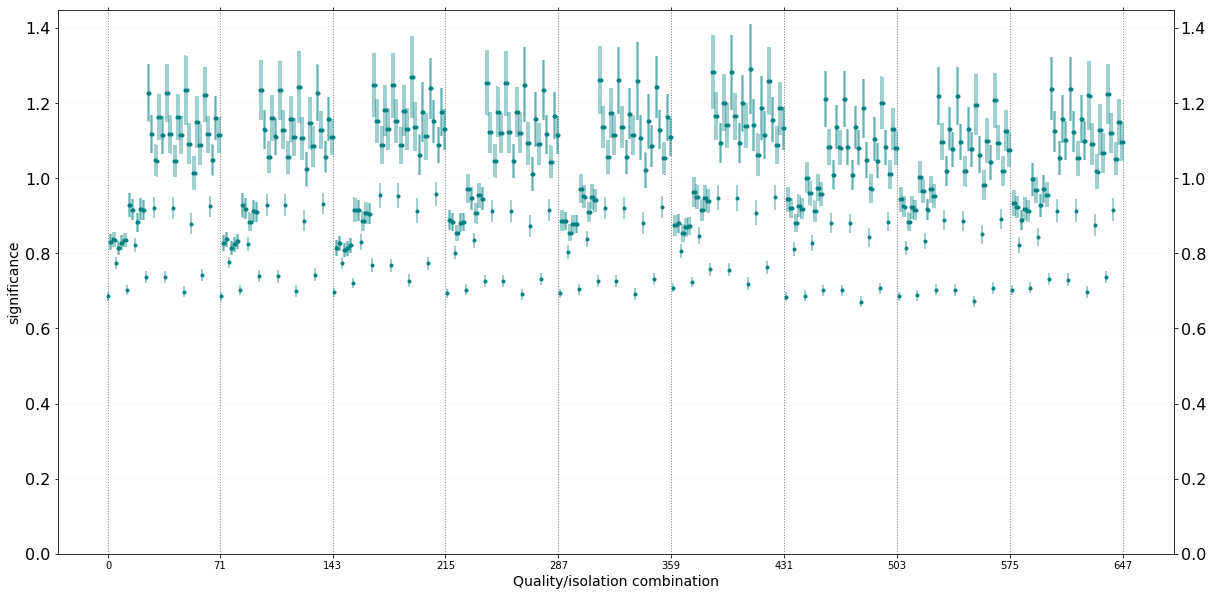

Loosest significance:
0.69 ± 0.01

Maximum significance:
1.29 ± 0.12
at value: 409

quality for electrons: medium 
quality for muons: tight
isolation for electrons: 4
isolation for muons: 1


In [47]:
x = range( n_qualities*n_iso )

# Uncomment a block:

title = 'significance'
y     = lep4_qual_iso_df['significance']
y_err  = lep4_qual_iso_df['significance-err']
color = 'teal'

# title = 'SF-inZ-significance'
# y     = lep4_qual_iso_df['SF-inZ-significance']
# y_err  = lep4_qual_iso_df['SF-inZ-significance-err']
# color = 'teal'

# title = 'SF-noZ-significance'
# y     = lep4_qual_iso_df['SF-noZ-significance']
# y_err  = lep4_qual_iso_df['SF-noZ-significance-err']
# color = 'teal'

# title = 'DF-significance'
# y     = lep4_qual_iso_df['DF-significance']
# y_err  = lep4_qual_iso_df['DF-significance-err']
# color = 'teal'

# title = 'signal'
# y     = lep4_qual_iso_df['signal']
# y_err  = lep4_qual_iso_df['signal-err']
# color = 'crimson'

# title = 'SF-inZ-signal'
# y     = lep4_qual_iso_df['SF-inZ-signal']
# y_err  = lep4_qual_iso_df['SF-inZ-signal-err']
# color = 'crimson'

# title = 'SF-noZ-signal'
# y     = lep4_qual_iso_df['SF-noZ-signal']
# y_err  = lep4_qual_iso_df['SF-noZ-signal-err']
# color = 'crimson'

# title = 'DF-signal'
# y     = lep4_qual_iso_df['DF-signal']
# y_err  = lep4_qual_iso_df['DF-signal-err']
# color = 'crimson'

# title = 'background'
# y     = lep4_qual_iso_df['background']
# y_err  = lep4_qual_iso_df['background-err']
# color = 'blue'

# title = 'SF-inZ-background'
# y     = lep4_qual_iso_df['SF-inZ-background']
# y_err  = lep4_qual_iso_df['SF-inZ-background-err']
# color = 'blue'

# title = 'SF-noZ-background'
# y     = lep4_qual_iso_df['SF-noZ-background']
# y_err  = lep4_qual_iso_df['SF-noZ-background-err']
# color = 'blue'

# title = 'DF-background'
# y     = lep4_qual_iso_df['DF-background']
# y_err  = lep4_qual_iso_df['DF-background-err']
# color = 'blue'

y = np.array(y)
y_err = np.array(y_err)

plt.figure(figsize=[20,10]) 
plt.plot(x, y, 'o', color=color, markersize=3)
plt.errorbar(x, y, yerr=y_err, 
             fmt=' ', capsize=0, color=color, alpha=0.5)
plt.xlabel("Quality/isolation combination", fontsize=14)
plt.xticks([0, 71, 143, 215, 287, 359, 431, 503, 575, 647], fontsize=10)
plt.ylabel(title, fontsize=14)
# plt.yscale('log')
# plt.ylabel('log({})'.format(title), fontsize=14)
plt.ylim(0)
plt.tick_params(bottom=True, top=True, left=True, right=True)
plt.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=True)
plt.yticks(fontsize=16)

plt.grid(axis="x", color="grey", alpha=1, linewidth=1, linestyle=":")
plt.grid(axis="y", color="grey", alpha=.5, linewidth=.25, linestyle=":")
plt.savefig('plots/Using_4_leptons_{}_{}.pdf'.format(title, identifier))
plt.show()

print('Loosest significance:'.format(title))
print("{:.2f} ± {:.2f}".format( y[0], y_err[0] ))
print()

print('Maximum significance:'.format(title))
index_max = np.argmax(y)
print("{:.2f} ± {:.2f}".format(y[index_max], y_err[index_max]))
print('at value: {}'.format(index_max))
print()

counter = 0
for quality in range(n_qualities): # qualities: LL, LM, LT, ML, MM, MT, TL, TM, TT
    for i in range(n_iso_electrons): # isolation for electrons, 0 means no iso
        for j in range(n_iso_muons): # isolation for muons, 0 means no iso
            if (counter == index_max):
                if (quality == 0):
                    print('quality for electrons: loose', '\nquality for muons: loose')
                if (quality == 1):
                    print('quality for electrons: loose', '\nquality for muons: medium')
                if (quality == 2):
                    print('quality for electrons: loose', '\nquality for muons: tight')
                if (quality == 3):
                    print('quality for electrons: medium', '\nquality for muons: loose')
                if (quality == 4):
                    print('quality for electrons: medium', '\nquality for muons: medium')
                if (quality == 5):
                    print('quality for electrons: medium', '\nquality for muons: tight')
                if (quality == 6):
                    print('quality for electrons: tight', '\nquality for muons: loose')
                if (quality == 7):
                    print('quality for electrons: tight', '\nquality for muons: medium')
                if (quality == 8):
                    print('quality for electrons: tight', '\nquality for muons: tight')
                print('isolation for electrons: {}'.format(i))
                print('isolation for muons: {}'.format(j))
            counter += 1


# Trying quality/isolation on the 3rd and 4th lepton:

You can load a dataframe from file or do a full event loop which is slow

In [42]:
lep34_qual_iso_df = pd.read_csv('csv/lep34_qual_iso_df.csv')

In [43]:
# lep34_qual_iso_df = pd.DataFrame()

# for n, df in zip([0,1],[sig, bkg]):
    
#     if (n == 0):
#         print("--- analyzing the signal")
#     if (n == 1):
#         print("--- analyzing the background")
        
#     y        = np.zeros((3,n_qualities*n_iso)) # for each SR
#     y_err    = np.zeros((3,n_qualities*n_iso)) # for each SR

#     for SR in [0,1,2]:
        
#         print('--- Signal Region = ', SR)
#         counter = -1 # counter will go from 0 to 647
#         sr_df = df[df.SR == SR].copy()
        
#         # Quality loop (LL, LM, LT, ML, MM, MT, TL, TM, TT)
#         for quality in range(n_qualities):
            
#             qual_df = sr_df.copy()
#             # Check quality
#             # LL
#             if (quality == 0): 
#                 pass
#             # LM
#             elif (quality == 1): 
#                 qual_df = qual_df[(abs(qual_df.lep4_pid) == 11) | (qual_df.lep4_medium == True)] # medium muons 
#                 qual_df = qual_df[(abs(qual_df.lep3_pid) == 11) | (qual_df.lep3_medium == True)] # medium muons
#             # LT
#             elif (quality == 2): 
#                 qual_df = qual_df[(abs(qual_df.lep4_pid) == 11) | (qual_df.lep4_tight == True)] # tight muons
#                 qual_df = qual_df[(abs(qual_df.lep3_pid) == 11) | (qual_df.lep3_tight == True)] # tight muons
#             # ML
#             elif (quality == 3): 
#                 qual_df = qual_df[(abs(qual_df.lep4_pid) == 13) | (qual_df.lep4_medium == True)] # medium electrons
#                 qual_df = qual_df[(abs(qual_df.lep3_pid) == 13) | (qual_df.lep3_medium == True)] # medium electrons
#             # MM
#             elif (quality == 4): 
#                 qual_df = qual_df[qual_df.lep4_medium == True] # medium all
#                 qual_df = qual_df[qual_df.lep3_medium == True] # medium all
#             # MT
#             elif (quality == 5): 
#                 qual_df = qual_df[(abs(qual_df.lep4_pid) == 13) | (qual_df.lep4_medium == True)] # medium electrons
#                 qual_df = qual_df[(abs(qual_df.lep4_pid) == 11) | (qual_df.lep4_tight == True)]  # tight muons
#                 qual_df = qual_df[(abs(qual_df.lep3_pid) == 13) | (qual_df.lep3_medium == True)] # medium electrons
#                 qual_df = qual_df[(abs(qual_df.lep3_pid) == 11) | (qual_df.lep3_tight == True)]  # tight muons
#             # TL
#             elif (quality == 6): 
#                 qual_df = qual_df[(abs(qual_df.lep4_pid) == 13) | (qual_df.lep4_tight == True)] # tight electrons
#                 qual_df = qual_df[(abs(qual_df.lep3_pid) == 13) | (qual_df.lep3_tight == True)] # tight electron3
#             # TM
#             elif (quality == 7):
#                 qual_df = qual_df[(abs(qual_df.lep4_pid) == 13) | (qual_df.lep4_tight == True)]  # tight electrons
#                 qual_df = qual_df[(abs(qual_df.lep4_pid) == 11) | (qual_df.lep4_medium == True)] # medium muons 
#                 qual_df = qual_df[(abs(qual_df.lep3_pid) == 13) | (qual_df.lep3_tight == True)]  # tight electrons
#                 qual_df = qual_df[(abs(qual_df.lep3_pid) == 11) | (qual_df.lep3_medium == True)] # medium muons
#             # TT
#             elif (quality == 8):
#                 qual_df = qual_df[qual_df.lep4_tight == True] # tight all
#                 qual_df = qual_df[qual_df.lep3_tight == True] # tight all

#             # Isolation loop for electrons, 0 means no iso
#             for i in range(n_iso_electrons): 
                
#                 iso_e_df = qual_df.copy()
#                 if (i == 0):
#                     pass
#                 else:
#                     iso_e_df = iso_e_df[(abs(iso_e_df.lep4_pid) == 13) | (iso_e_df['lep4_iso_{}'.format(i)] == True)] # iso_i electrons
#                     iso_e_df = iso_e_df[(abs(iso_e_df.lep3_pid) == 13) | (iso_e_df['lep3_iso_{}'.format(i)] == True)] # iso_i electrons
                
#                 # Isolation loop for muons, 0 means no iso
#                 for j in range(n_iso_muons):
                    
#                     iso_mu_df = iso_e_df.copy()
#                     if (j == 0):
#                         pass
#                     else:
#                         iso_mu_df = iso_mu_df[(abs(iso_mu_df.lep4_pid) == 11) | (iso_mu_df['lep4_iso_{}'.format(j)] == True)] # iso_j muons
#                         iso_mu_df = iso_mu_df[(abs(iso_mu_df.lep3_pid) == 11) | (iso_mu_df['lep3_iso_{}'.format(j)] == True)] # iso_j muons
                        
#                     counter += 1
#                     print('counter = ', counter)

#                     y[SR][counter]     = sum(iso_mu_df['wgt'])
#                     y_err[SR][counter] = sum(iso_mu_df['wgt']**2)

#     y_err[0] = np.sqrt(y_err[0])
#     y_err[1] = np.sqrt(y_err[1])
#     y_err[2] = np.sqrt(y_err[2])

#     # Saving information:
#     if (n == 0):
#         lep34_qual_iso_df['SF-inZ-signal']     = pd.Series(y[0])
#         lep34_qual_iso_df['SF-inZ-signal-err'] = pd.Series(y_err[0])
#         lep34_qual_iso_df['SF-noZ-signal']     = pd.Series(y[1])
#         lep34_qual_iso_df['SF-noZ-signal-err'] = pd.Series(y_err[1])
#         lep34_qual_iso_df['DF-signal']         = pd.Series(y[2])
#         lep34_qual_iso_df['DF-signal-err']     = pd.Series(y_err[2])
#         lep34_qual_iso_df['signal']            = pd.Series(y[0]+y[1]+y[2])
#         lep34_qual_iso_df['signal-err']        = pd.Series(np.sqrt(y_err[0]**2 + y_err[1]**2 + y_err[2]**2))
        
#     if (n == 1):
#         lep34_qual_iso_df['SF-inZ-background']     = pd.Series(y[0])
#         lep34_qual_iso_df['SF-inZ-background-err'] = pd.Series(y_err[0])
#         lep34_qual_iso_df['SF-noZ-background']     = pd.Series(y[1])
#         lep34_qual_iso_df['SF-noZ-background-err'] = pd.Series(y_err[1])
#         lep34_qual_iso_df['DF-background']         = pd.Series(y[2])
#         lep34_qual_iso_df['DF-background-err']     = pd.Series(y_err[2])
#         lep34_qual_iso_df['background']            = pd.Series(y[0]+y[1]+y[2])
#         lep34_qual_iso_df['background-err']        = pd.Series(np.sqrt(y_err[0]**2 + y_err[1]**2 + y_err[2]**2))
        
        
# # Calculating the significances
# print("Calculating the significances")
# significances = [[],[],[],[]] 
# errors = [[],[],[],[]]

# for choice in lep34_qual_iso_df.index:

#     # SF-inZ
#     significance, error = significance_and_error(lep34_qual_iso_df.at[choice,'SF-inZ-signal'], \
#                                                  lep34_qual_iso_df.at[choice,'SF-inZ-signal-err'], \
#                                                  lep34_qual_iso_df.at[choice,'SF-inZ-background'], \
#                                                  lep34_qual_iso_df.at[choice,'SF-inZ-background-err'])
#     significances[0].append(significance)
#     errors[0].append(error)
#     # SF-noZ
#     significance, error = significance_and_error(lep34_qual_iso_df.at[choice,'SF-noZ-signal'], \
#                                                  lep34_qual_iso_df.at[choice,'SF-noZ-signal-err'], \
#                                                  lep34_qual_iso_df.at[choice,'SF-noZ-background'], \
#                                                  lep34_qual_iso_df.at[choice,'SF-noZ-background-err'])
#     significances[1].append(significance)
#     errors[1].append(error)
#     # DF
#     significance, error = significance_and_error(lep34_qual_iso_df.at[choice,'DF-signal'], \
#                                                  lep34_qual_iso_df.at[choice,'DF-signal-err'], \
#                                                  lep34_qual_iso_df.at[choice,'DF-background'], \
#                                                  lep34_qual_iso_df.at[choice,'DF-background-err'])
#     significances[2].append(significance)
#     errors[2].append(error)
#     # Quadrature
#     significance, error = add_in_quadrature_3((significances[0][-1], errors[0][-1]), 
#                                               (significances[1][-1], errors[1][-1]),
#                                               (significances[2][-1], errors[2][-1]),)
#     significances[3].append(significance)
#     errors[3].append(error)
    
# lep34_qual_iso_df['SF-inZ-significance']     = pd.Series(significances[0])
# lep34_qual_iso_df['SF-inZ-significance-err'] = pd.Series(errors[0])
# lep34_qual_iso_df['SF-noZ-significance']     = pd.Series(significances[1])
# lep34_qual_iso_df['SF-noZ-significance-err'] = pd.Series(errors[1])
# lep34_qual_iso_df['DF-significance']         = pd.Series(significances[2])
# lep34_qual_iso_df['DF-significance-err']     = pd.Series(errors[2])
# lep34_qual_iso_df['significance']            = pd.Series(significances[3])
# lep34_qual_iso_df['significance-err']        = pd.Series(errors[3])
# print("--- Done!")

In [44]:
# lep34_qual_iso_df.to_csv('lep34_qual_iso_df.csv')

Plot any quantity vs quality/isolation

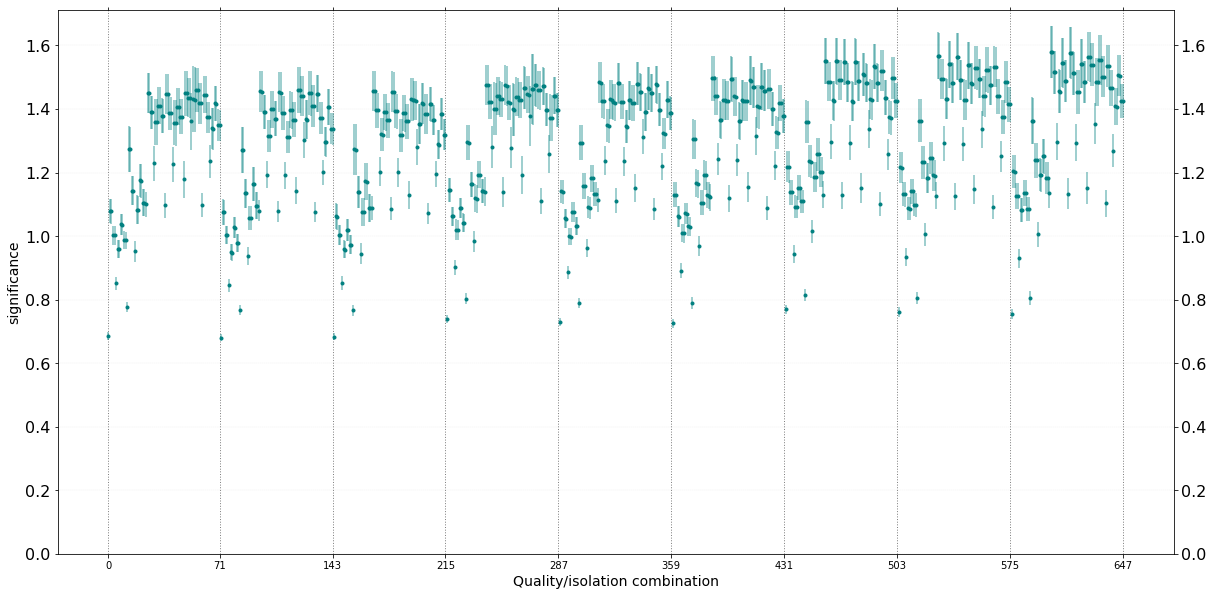

Loosest significance:
0.69 ± 0.01

Maximum significance:
1.58 ± 0.08
at value: 601

quality for electrons: tight 
quality for muons: tight
isolation for electrons: 2
isolation for muons: 1


In [46]:
x = range( n_qualities*n_iso )

# Uncomment a block:

title = 'significance'
y     = lep34_qual_iso_df['significance']
y_err  = lep34_qual_iso_df['significance-err']
color = 'teal'

# title = 'SF-inZ-significance'
# y     = lep34_qual_iso_df['SF-inZ-significance']
# y_err  = lep34_qual_iso_df['SF-inZ-significance-err']
# color = 'teal'

# title = 'SF-noZ-significance'
# y     = lep34_qual_iso_df['SF-noZ-significance']
# y_err  = lep34_qual_iso_df['SF-noZ-significance-err']
# color = 'teal'

# title = 'DF-significance'
# y     = lep34_qual_iso_df['DF-significance']
# y_err  = lep34_qual_iso_df['DF-significance-err']
# color = 'teal'

# title = 'signal'
# y     = lep34_qual_iso_df['signal']
# y_err  = lep34_qual_iso_df['signal-err']
# color = 'crimson'

# title = 'SF-inZ-signal'
# y     = lep34_qual_iso_df['SF-inZ-signal']
# y_err  = lep34_qual_iso_df['SF-inZ-signal-err']
# color = 'crimson'

# title = 'SF-noZ-signal'
# y     = lep34_qual_iso_df['SF-noZ-signal']
# y_err  = lep34_qual_iso_df['SF-noZ-signal-err']
# color = 'crimson'

# title = 'DF-signal'
# y     = lep34_qual_iso_df['DF-signal']
# y_err  = lep34_qual_iso_df['DF-signal-err']
# color = 'crimson'

# title = 'background'
# y     = lep34_qual_iso_df['background']
# y_err  = lep34_qual_iso_df['background-err']
# color = 'blue'

# title = 'SF-inZ-background'
# y     = lep34_qual_iso_df['SF-inZ-background']
# y_err  = lep34_qual_iso_df['SF-inZ-background-err']
# color = 'blue'

# title = 'SF-noZ-background'
# y     = lep34_qual_iso_df['SF-noZ-background']
# y_err  = lep34_qual_iso_df['SF-noZ-background-err']
# color = 'blue'

# title = 'DF-background'
# y     = lep34_qual_iso_df['DF-background']
# y_err  = lep34_qual_iso_df['DF-background-err']
# color = 'blue'

y = np.array(y)
y_err = np.array(y_err)

plt.figure(figsize=[20,10]) 
plt.plot(x, y, 'o', color=color, markersize=3)
plt.errorbar(x, y, yerr=y_err, 
             fmt=' ', capsize=0, color=color, alpha=0.5)
plt.xlabel("Quality/isolation combination", fontsize=14)
plt.xticks([0, 71, 143, 215, 287, 359, 431, 503, 575, 647], fontsize=10)
plt.ylabel(title, fontsize=14)
# plt.yscale('log')
# plt.ylabel('log({})'.format(title), fontsize=14)
plt.ylim(0)
plt.tick_params(bottom=True, top=True, left=True, right=True)
plt.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=True)
plt.yticks(fontsize=16)

plt.grid(axis="x", color="grey", alpha=1, linewidth=1, linestyle=":")
plt.grid(axis="y", color="grey", alpha=.5, linewidth=.25, linestyle=":")
plt.savefig('plots/Using_34_leptons_{}_{}.pdf'.format(title, identifier))
plt.show()

print('Loosest significance:'.format(title))
print("{:.2f} ± {:.2f}".format( y[0], y_err[0] ))
print()

print('Maximum significance:'.format(title))
index_max = np.argmax(y)
print("{:.2f} ± {:.2f}".format(y[index_max], y_err[index_max]))
print('at value: {}'.format(index_max))
print()

counter = 0
for quality in range(n_qualities): # qualities: LL, LM, LT, ML, MM, MT, TL, TM, TT
    for i in range(n_iso_electrons): # isolation for electrons, 0 means no iso
        for j in range(n_iso_muons): # isolation for muons, 0 means no iso
            if (counter == index_max):
                if (quality == 0):
                    print('quality for electrons: loose', '\nquality for muons: loose')
                if (quality == 1):
                    print('quality for electrons: loose', '\nquality for muons: medium')
                if (quality == 2):
                    print('quality for electrons: loose', '\nquality for muons: tight')
                if (quality == 3):
                    print('quality for electrons: medium', '\nquality for muons: loose')
                if (quality == 4):
                    print('quality for electrons: medium', '\nquality for muons: medium')
                if (quality == 5):
                    print('quality for electrons: medium', '\nquality for muons: tight')
                if (quality == 6):
                    print('quality for electrons: tight', '\nquality for muons: loose')
                if (quality == 7):
                    print('quality for electrons: tight', '\nquality for muons: medium')
                if (quality == 8):
                    print('quality for electrons: tight', '\nquality for muons: tight')
                print('isolation for electrons: {}'.format(i))
                print('isolation for muons: {}'.format(j))
            counter += 1


# Trying quality/isolation on the 2nd, 3rd and 4th lepton:

You can load a dataframe from file or do a full event loop which is slow

In [48]:
lep234_qual_iso_df = pd.read_csv('csv/lep234_qual_iso_df.csv')

In [35]:
# lep234_qual_iso_df = pd.DataFrame()

# for n, df in zip([0,1],[sig, bkg]):
    
#     if (n == 0):
#         print("--- analyzing the signal")
#     if (n == 1):
#         print("--- analyzing the background")
        
#     y        = np.zeros((3,n_qualities*n_iso)) # for each SR
#     y_err    = np.zeros((3,n_qualities*n_iso)) # for each SR

#     for SR in [0,1,2]:
        
#         print('--- Signal Region = ', SR)
#         counter = -1 # counter will go from 0 to 647
#         sr_df = df[df.SR == SR].copy()
        
#         # Quality loop (LL, LM, LT, ML, MM, MT, TL, TM, TT)
#         for quality in range(n_qualities):
            
#             qual_df = sr_df.copy()
#             # Check quality
#             # LL
#             if (quality == 0): 
#                 pass
#             # LM
#             elif (quality == 1): 
#                 qual_df = qual_df[(abs(qual_df.lep4_pid) == 11) | (qual_df.lep4_medium == True)] # medium muons 
#                 qual_df = qual_df[(abs(qual_df.lep3_pid) == 11) | (qual_df.lep3_medium == True)] # medium muons
#                 qual_df = qual_df[(abs(qual_df.lep2_pid) == 11) | (qual_df.lep2_medium == True)] # medium muons
#             # LT
#             elif (quality == 2): 
#                 qual_df = qual_df[(abs(qual_df.lep4_pid) == 11) | (qual_df.lep4_tight == True)] # tight muons
#                 qual_df = qual_df[(abs(qual_df.lep3_pid) == 11) | (qual_df.lep3_tight == True)] # tight muons
#                 qual_df = qual_df[(abs(qual_df.lep2_pid) == 11) | (qual_df.lep2_tight == True)] # tight muons
#             # ML
#             elif (quality == 3): 
#                 qual_df = qual_df[(abs(qual_df.lep4_pid) == 13) | (qual_df.lep4_medium == True)] # medium electrons
#                 qual_df = qual_df[(abs(qual_df.lep3_pid) == 13) | (qual_df.lep3_medium == True)] # medium electrons
#                 qual_df = qual_df[(abs(qual_df.lep2_pid) == 13) | (qual_df.lep2_medium == True)] # medium electrons
#             # MM
#             elif (quality == 4): 
#                 qual_df = qual_df[qual_df.lep4_medium == True] # medium all
#                 qual_df = qual_df[qual_df.lep3_medium == True] # medium all
#                 qual_df = qual_df[qual_df.lep2_medium == True] # medium all
#             # MT
#             elif (quality == 5): 
#                 qual_df = qual_df[(abs(qual_df.lep4_pid) == 13) | (qual_df.lep4_medium == True)] # medium electrons
#                 qual_df = qual_df[(abs(qual_df.lep4_pid) == 11) | (qual_df.lep4_tight == True)]  # tight muons
#                 qual_df = qual_df[(abs(qual_df.lep3_pid) == 13) | (qual_df.lep3_medium == True)] # medium electrons
#                 qual_df = qual_df[(abs(qual_df.lep3_pid) == 11) | (qual_df.lep3_tight == True)]  # tight muons
#                 qual_df = qual_df[(abs(qual_df.lep2_pid) == 13) | (qual_df.lep2_medium == True)] # medium electrons
#                 qual_df = qual_df[(abs(qual_df.lep2_pid) == 11) | (qual_df.lep2_tight == True)]  # tight muons

#             # TL
#             elif (quality == 6): 
#                 qual_df = qual_df[(abs(qual_df.lep4_pid) == 13) | (qual_df.lep4_tight == True)] # tight electrons
#                 qual_df = qual_df[(abs(qual_df.lep3_pid) == 13) | (qual_df.lep3_tight == True)] # tight electrons
#                 qual_df = qual_df[(abs(qual_df.lep2_pid) == 13) | (qual_df.lep2_tight == True)] # tight electrons
#             # TM
#             elif (quality == 7):
#                 qual_df = qual_df[(abs(qual_df.lep4_pid) == 13) | (qual_df.lep4_tight == True)]  # tight electrons
#                 qual_df = qual_df[(abs(qual_df.lep4_pid) == 11) | (qual_df.lep4_medium == True)] # medium muons 
#                 qual_df = qual_df[(abs(qual_df.lep3_pid) == 13) | (qual_df.lep3_tight == True)]  # tight electrons
#                 qual_df = qual_df[(abs(qual_df.lep3_pid) == 11) | (qual_df.lep3_medium == True)] # medium muons
#                 qual_df = qual_df[(abs(qual_df.lep2_pid) == 13) | (qual_df.lep2_tight == True)]  # tight electrons
#                 qual_df = qual_df[(abs(qual_df.lep2_pid) == 11) | (qual_df.lep2_medium == True)] # medium muons
#             # TT
#             elif (quality == 8):
#                 qual_df = qual_df[qual_df.lep4_tight == True] # tight all
#                 qual_df = qual_df[qual_df.lep3_tight == True] # tight all
#                 qual_df = qual_df[qual_df.lep2_tight == True] # tight all

#             # Isolation loop for electrons, 0 means no iso
#             for i in range(n_iso_electrons): 
                
#                 iso_e_df = qual_df.copy()
#                 if (i == 0):
#                     pass
#                 else:
#                     iso_e_df = iso_e_df[(abs(iso_e_df.lep4_pid) == 13) | (iso_e_df['lep4_iso_{}'.format(i)] == True)] # iso_i electrons
#                     iso_e_df = iso_e_df[(abs(iso_e_df.lep3_pid) == 13) | (iso_e_df['lep3_iso_{}'.format(i)] == True)] # iso_i electrons
#                     iso_e_df = iso_e_df[(abs(iso_e_df.lep2_pid) == 13) | (iso_e_df['lep2_iso_{}'.format(i)] == True)] # iso_i electrons
                
#                 # Isolation loop for muons, 0 means no iso
#                 for j in range(n_iso_muons):
                    
#                     iso_mu_df = iso_e_df.copy()
#                     if (j == 0):
#                         pass
#                     else:
#                         iso_mu_df = iso_mu_df[(abs(iso_mu_df.lep4_pid) == 11) | (iso_mu_df['lep4_iso_{}'.format(j)] == True)] # iso_j muons
#                         iso_mu_df = iso_mu_df[(abs(iso_mu_df.lep3_pid) == 11) | (iso_mu_df['lep3_iso_{}'.format(j)] == True)] # iso_j muons
#                         iso_mu_df = iso_mu_df[(abs(iso_mu_df.lep2_pid) == 11) | (iso_mu_df['lep2_iso_{}'.format(j)] == True)] # iso_j muons
                        
#                     counter += 1
#                     print('counter = ', counter)

#                     y[SR][counter]     = sum(iso_mu_df['wgt'])
#                     y_err[SR][counter] = sum(iso_mu_df['wgt']**2)

#     y_err[0] = np.sqrt(y_err[0])
#     y_err[1] = np.sqrt(y_err[1])
#     y_err[2] = np.sqrt(y_err[2])

#     # Saving information:
#     if (n == 0):
#         lep234_qual_iso_df['SF-inZ-signal']     = pd.Series(y[0])
#         lep234_qual_iso_df['SF-inZ-signal-err'] = pd.Series(y_err[0])
#         lep234_qual_iso_df['SF-noZ-signal']     = pd.Series(y[1])
#         lep234_qual_iso_df['SF-noZ-signal-err'] = pd.Series(y_err[1])
#         lep234_qual_iso_df['DF-signal']         = pd.Series(y[2])
#         lep234_qual_iso_df['DF-signal-err']     = pd.Series(y_err[2])
#         lep234_qual_iso_df['signal']            = pd.Series(y[0]+y[1]+y[2])
#         lep234_qual_iso_df['signal-err']        = pd.Series(np.sqrt(y_err[0]**2 + y_err[1]**2 + y_err[2]**2))
        
#     if (n == 1):
#         lep234_qual_iso_df['SF-inZ-background']     = pd.Series(y[0])
#         lep234_qual_iso_df['SF-inZ-background-err'] = pd.Series(y_err[0])
#         lep234_qual_iso_df['SF-noZ-background']     = pd.Series(y[1])
#         lep234_qual_iso_df['SF-noZ-background-err'] = pd.Series(y_err[1])
#         lep234_qual_iso_df['DF-background']         = pd.Series(y[2])
#         lep234_qual_iso_df['DF-background-err']     = pd.Series(y_err[2])
#         lep234_qual_iso_df['background']            = pd.Series(y[0]+y[1]+y[2])
#         lep234_qual_iso_df['background-err']        = pd.Series(np.sqrt(y_err[0]**2 + y_err[1]**2 + y_err[2]**2))
        
        
# # Calculating the significances
# print("Calculating the significances")
# significances = [[],[],[],[]] 
# errors = [[],[],[],[]]

# for choice in lep234_qual_iso_df.index:

#     # SF-inZ
#     significance, error = significance_and_error(lep234_qual_iso_df.at[choice,'SF-inZ-signal'], \
#                                                  lep234_qual_iso_df.at[choice,'SF-inZ-signal-err'], \
#                                                  lep234_qual_iso_df.at[choice,'SF-inZ-background'], \
#                                                  lep234_qual_iso_df.at[choice,'SF-inZ-background-err'])
#     significances[0].append(significance)
#     errors[0].append(error)
#     # SF-noZ
#     significance, error = significance_and_error(lep234_qual_iso_df.at[choice,'SF-noZ-signal'], \
#                                                  lep234_qual_iso_df.at[choice,'SF-noZ-signal-err'], \
#                                                  lep234_qual_iso_df.at[choice,'SF-noZ-background'], \
#                                                  lep234_qual_iso_df.at[choice,'SF-noZ-background-err'])
#     significances[1].append(significance)
#     errors[1].append(error)
#     # DF
#     significance, error = significance_and_error(lep234_qual_iso_df.at[choice,'DF-signal'], \
#                                                  lep234_qual_iso_df.at[choice,'DF-signal-err'], \
#                                                  lep234_qual_iso_df.at[choice,'DF-background'], \
#                                                  lep234_qual_iso_df.at[choice,'DF-background-err'])
#     significances[2].append(significance)
#     errors[2].append(error)
#     # Quadrature
#     significance, error = add_in_quadrature_3((significances[0][-1], errors[0][-1]), 
#                                               (significances[1][-1], errors[1][-1]),
#                                               (significances[2][-1], errors[2][-1]),)
#     significances[3].append(significance)
#     errors[3].append(error)
    
# lep234_qual_iso_df['SF-inZ-significance']     = pd.Series(significances[0])
# lep234_qual_iso_df['SF-inZ-significance-err'] = pd.Series(errors[0])
# lep234_qual_iso_df['SF-noZ-significance']     = pd.Series(significances[1])
# lep234_qual_iso_df['SF-noZ-significance-err'] = pd.Series(errors[1])
# lep234_qual_iso_df['DF-significance']         = pd.Series(significances[2])
# lep234_qual_iso_df['DF-significance-err']     = pd.Series(errors[2])
# lep234_qual_iso_df['significance']            = pd.Series(significances[3])
# lep234_qual_iso_df['significance-err']        = pd.Series(errors[3])
# print("--- Done!")

In [36]:
# lep234_qual_iso_df.to_csv('lep234_qual_iso_df.csv')

Plot any quantity vs quality/isolation

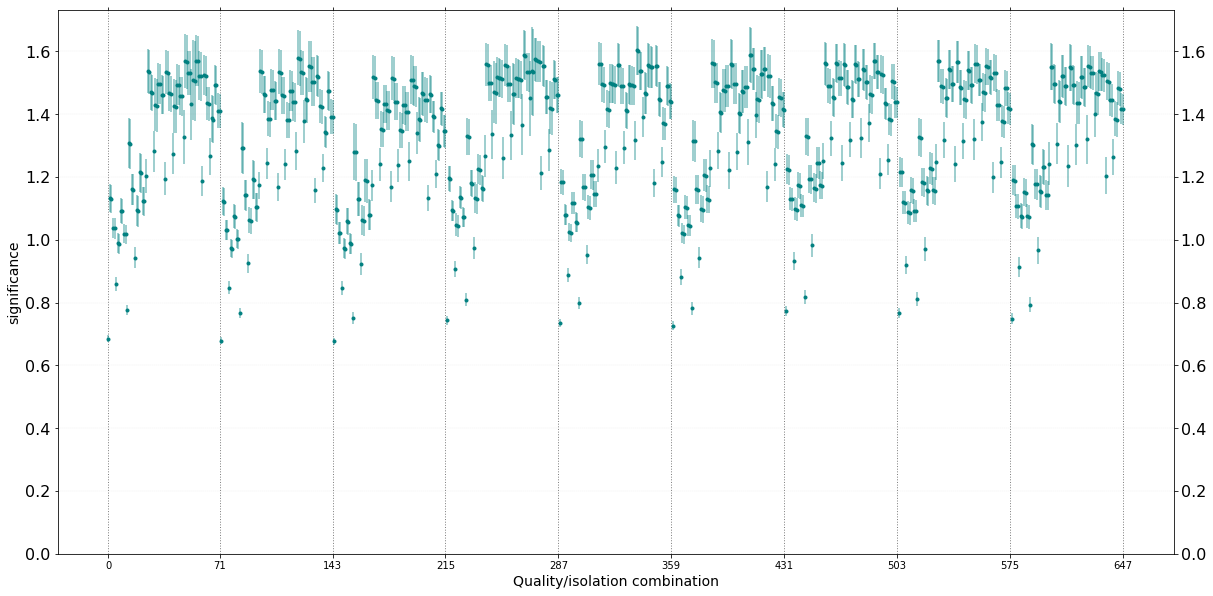

Loosest significance:
0.69 ± 0.01

Maximum significance:
1.60 ± 0.08
at value: 337

quality for electrons: medium 
quality for muons: medium
isolation for electrons: 4
isolation for muons: 1


In [49]:
x = range( n_qualities*n_iso )

# Uncomment a block:

title = 'significance'
y     = lep234_qual_iso_df['significance']
y_err  = lep234_qual_iso_df['significance-err']
color = 'teal'

# title = 'SF-inZ-significance'
# y     = lep234_qual_iso_df['SF-inZ-significance']
# y_err  = lep234_qual_iso_df['SF-inZ-significance-err']
# color = 'teal'

# title = 'SF-noZ-significance'
# y     = lep234_qual_iso_df['SF-noZ-significance']
# y_err  = lep234_qual_iso_df['SF-noZ-significance-err']
# color = 'teal'

# title = 'DF-significance'
# y     = lep234_qual_iso_df['DF-significance']
# y_err  = lep234_qual_iso_df['DF-significance-err']
# color = 'teal'

# title = 'signal'
# y     = lep234_qual_iso_df['signal']
# y_err  = lep234_qual_iso_df['signal-err']
# color = 'crimson'

# title = 'SF-inZ-signal'
# y     = lep234_qual_iso_df['SF-inZ-signal']
# y_err  = lep234_qual_iso_df['SF-inZ-signal-err']
# color = 'crimson'

# title = 'SF-noZ-signal'
# y     = lep234_qual_iso_df['SF-noZ-signal']
# y_err  = lep234_qual_iso_df['SF-noZ-signal-err']
# color = 'crimson'

# title = 'DF-signal'
# y     = lep234_qual_iso_df['DF-signal']
# y_err  = lep234_qual_iso_df['DF-signal-err']
# color = 'crimson'

# title = 'background'
# y     = lep234_qual_iso_df['background']
# y_err  = lep234_qual_iso_df['background-err']
# color = 'blue'

# title = 'SF-inZ-background'
# y     = lep234_qual_iso_df['SF-inZ-background']
# y_err  = lep234_qual_iso_df['SF-inZ-background-err']
# color = 'blue'

# title = 'SF-noZ-background'
# y     = lep234_qual_iso_df['SF-noZ-background']
# y_err  = lep234_qual_iso_df['SF-noZ-background-err']
# color = 'blue'

# title = 'DF-background'
# y     = lep234_qual_iso_df['DF-background']
# y_err  = lep234_qual_iso_df['DF-background-err']
# color = 'blue'

y = np.array(y)
y_err = np.array(y_err)

plt.figure(figsize=[20,10]) 
plt.plot(x, y, 'o', color=color, markersize=3)
plt.errorbar(x, y, yerr=y_err, 
             fmt=' ', capsize=0, color=color, alpha=0.5)
plt.xlabel("Quality/isolation combination", fontsize=14)
plt.xticks([0, 71, 143, 215, 287, 359, 431, 503, 575, 647], fontsize=10)
plt.ylabel(title, fontsize=14)
# plt.yscale('log')
# plt.ylabel('log({})'.format(title), fontsize=14)
plt.ylim(0)
plt.tick_params(bottom=True, top=True, left=True, right=True)
plt.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=True)
plt.yticks(fontsize=16)

plt.grid(axis="x", color="grey", alpha=1, linewidth=1, linestyle=":")
plt.grid(axis="y", color="grey", alpha=.5, linewidth=.25, linestyle=":")
plt.savefig('plots/Using_234_leptons_{}_{}.pdf'.format(title, identifier))
plt.show()

print('Loosest significance:'.format(title))
print("{:.2f} ± {:.2f}".format( y[0], y_err[0] ))
print()

print('Maximum significance:'.format(title))
index_max = np.argmax(y)
print("{:.2f} ± {:.2f}".format(y[index_max], y_err[index_max]))
print('at value: {}'.format(index_max))
print()

counter = 0
for quality in range(n_qualities): # qualities: LL, LM, LT, ML, MM, MT, TL, TM, TT
    for i in range(n_iso_electrons): # isolation for electrons, 0 means no iso
        for j in range(n_iso_muons): # isolation for muons, 0 means no iso
            if (counter == index_max):
                if (quality == 0):
                    print('quality for electrons: loose', '\nquality for muons: loose')
                if (quality == 1):
                    print('quality for electrons: loose', '\nquality for muons: medium')
                if (quality == 2):
                    print('quality for electrons: loose', '\nquality for muons: tight')
                if (quality == 3):
                    print('quality for electrons: medium', '\nquality for muons: loose')
                if (quality == 4):
                    print('quality for electrons: medium', '\nquality for muons: medium')
                if (quality == 5):
                    print('quality for electrons: medium', '\nquality for muons: tight')
                if (quality == 6):
                    print('quality for electrons: tight', '\nquality for muons: loose')
                if (quality == 7):
                    print('quality for electrons: tight', '\nquality for muons: medium')
                if (quality == 8):
                    print('quality for electrons: tight', '\nquality for muons: tight')
                print('isolation for electrons: {}'.format(i))
                print('isolation for muons: {}'.format(j))
            counter += 1

# Trying quality/isolation on the Z-leptons and another combination on the W-leptons

You can load a dataframe from file or do a full event loop which is slow

In [25]:
ZW_qual_iso_df = pd.read_csv('csv/ZW_qual_iso_df.csv')
ZW_qual_iso_df = pd.read_csv('csv/ZW_qual_iso_df_new.csv')

In [24]:
# sig = sig[sig.index < 1]
# bkg = bkg[bkg.index < 1]

In [8]:
ZW_qual_iso_df = pd.DataFrame()

for n, df in zip([0,1],[sig, bkg]):
    
    if (n == 0):
        print("--- analyzing the signal")
    if (n == 1):
        print("--- analyzing the background")
        
    y        = np.zeros((3,(n_qualities*n_iso)**2)) # for each SR
    y_err    = np.zeros((3,(n_qualities*n_iso)**2)) # for each SR
    
    counter = -1 # counter will go from 0 to 647**2
        
    # Quality loop (LL, LM, LT, ML, MM, MT, TL, TM, TT)
    for Z_quality in range(n_qualities):

        qual_df = df.copy()
        # Check quality
        # LL
        if (Z_quality == 0): 
            pass
        # LM
        elif (Z_quality == 1): 
            qual_df = qual_df[(abs(qual_df.Zlep1_pid) == 11) | (qual_df.Zlep1_medium == True)] # medium muons 
            qual_df = qual_df[(abs(qual_df.Zlep2_pid) == 11) | (qual_df.Zlep2_medium == True)] # medium muons
        # LT
        elif (Z_quality == 2): 
            qual_df = qual_df[(abs(qual_df.Zlep1_pid) == 11) | (qual_df.Zlep1_tight == True)] # tight muons
            qual_df = qual_df[(abs(qual_df.Zlep2_pid) == 11) | (qual_df.Zlep2_tight == True)] # tight muons
        # ML
        elif (Z_quality == 3): 
            qual_df = qual_df[(abs(qual_df.Zlep1_pid) == 13) | (qual_df.Zlep1_medium == True)] # medium electrons
            qual_df = qual_df[(abs(qual_df.Zlep2_pid) == 13) | (qual_df.Zlep2_medium == True)] # medium electrons
        # MM
        elif (Z_quality == 4): 
            qual_df = qual_df[qual_df.Zlep1_medium == True] # medium all
            qual_df = qual_df[qual_df.Zlep2_medium == True] # medium all
        # MT
        elif (Z_quality == 5): 
            qual_df = qual_df[(abs(qual_df.Zlep1_pid) == 13) | (qual_df.Zlep1_medium == True)] # medium electrons
            qual_df = qual_df[(abs(qual_df.Zlep1_pid) == 11) | (qual_df.Zlep1_tight == True)]  # tight muons
            qual_df = qual_df[(abs(qual_df.Zlep2_pid) == 13) | (qual_df.Zlep2_medium == True)] # medium electrons
            qual_df = qual_df[(abs(qual_df.Zlep2_pid) == 11) | (qual_df.Zlep2_tight == True)]  # tight muons
        # TL
        elif (Z_quality == 6): 
            qual_df = qual_df[(abs(qual_df.Zlep1_pid) == 13) | (qual_df.Zlep1_tight == True)] # tight electrons
            qual_df = qual_df[(abs(qual_df.Zlep2_pid) == 13) | (qual_df.Zlep2_tight == True)] # tight electrons
        # TM
        elif (Z_quality == 7):
            qual_df = qual_df[(abs(qual_df.Zlep1_pid) == 13) | (qual_df.Zlep1_tight == True)]  # tight electrons
            qual_df = qual_df[(abs(qual_df.Zlep1_pid) == 11) | (qual_df.Zlep1_medium == True)] # medium muons 
            qual_df = qual_df[(abs(qual_df.Zlep2_pid) == 13) | (qual_df.Zlep2_tight == True)]  # tight electrons
            qual_df = qual_df[(abs(qual_df.Zlep2_pid) == 11) | (qual_df.Zlep2_medium == True)] # medium muons
        # TT
        elif (Z_quality == 8):
            qual_df = qual_df[qual_df.Zlep1_tight == True] # tight all
            qual_df = qual_df[qual_df.Zlep2_tight == True] # tight all

        # Isolation loop for electrons, 0 means no iso
        for i in range(n_iso_electrons): 

            Z_iso_e_df = qual_df.copy()
            if (i == 0):
                pass
            else:
                Z_iso_e_df = Z_iso_e_df[(abs(Z_iso_e_df.Zlep1_pid) == 13) | (Z_iso_e_df['Zlep1_iso_{}'.format(i)] == True)] # iso_i electrons
                Z_iso_e_df = Z_iso_e_df[(abs(Z_iso_e_df.Zlep2_pid) == 13) | (Z_iso_e_df['Zlep2_iso_{}'.format(i)] == True)] # iso_i electrons

            # Isolation loop for muons, 0 means no iso
            for j in range(n_iso_muons):

                Z_iso_mu_df = Z_iso_e_df.copy()
                if (j == 0):
                    pass
                else:
                    Z_iso_mu_df = Z_iso_mu_df[(abs(Z_iso_mu_df.Zlep1_pid) == 11) | (Z_iso_mu_df['Zlep1_iso_{}'.format(j)] == True)] # iso_j muons
                    Z_iso_mu_df = Z_iso_mu_df[(abs(Z_iso_mu_df.Zlep2_pid) == 11) | (Z_iso_mu_df['Zlep2_iso_{}'.format(j)] == True)] # iso_j muons


                # ---------- W lepton analysis ----------

                # Quality loop (LL, LM, LT, ML, MM, MT, TL, TM, TT)
                for W_quality in range(n_qualities):

                    W_qual_df = Z_iso_mu_df.copy()
                    # Check quality
                    # LL
                    if (W_quality == 0): 
                        pass
                    # LM
                    elif (W_quality == 1): 
                        W_qual_df = W_qual_df[(abs(W_qual_df.Wlep1_pid) == 11) | (W_qual_df.Wlep1_medium == True)] # medium muons 
                        W_qual_df = W_qual_df[(abs(W_qual_df.Wlep2_pid) == 11) | (W_qual_df.Wlep2_medium == True)] # medium muons
                    # LT
                    elif (W_quality == 2): 
                        W_qual_df = W_qual_df[(abs(W_qual_df.Wlep1_pid) == 11) | (W_qual_df.Wlep1_tight == True)] # tight muons
                        W_qual_df = W_qual_df[(abs(W_qual_df.Wlep2_pid) == 11) | (W_qual_df.Wlep2_tight == True)] # tight muons
                    # ML
                    elif (W_quality == 3): 
                        W_qual_df = W_qual_df[(abs(W_qual_df.Wlep1_pid) == 13) | (W_qual_df.Wlep1_medium == True)] # medium electrons
                        W_qual_df = W_qual_df[(abs(W_qual_df.Wlep2_pid) == 13) | (W_qual_df.Wlep2_medium == True)] # medium electrons
                    # MM
                    elif (W_quality == 4): 
                        W_qual_df = W_qual_df[W_qual_df.Wlep1_medium == True] # medium all
                        W_qual_df = W_qual_df[W_qual_df.Wlep2_medium == True] # medium all
                    # MT
                    elif (W_quality == 5): 
                        W_qual_df = W_qual_df[(abs(W_qual_df.Wlep1_pid) == 13) | (W_qual_df.Wlep1_medium == True)] # medium electrons
                        W_qual_df = W_qual_df[(abs(W_qual_df.Wlep1_pid) == 11) | (W_qual_df.Wlep1_tight == True)]  # tight muons
                        W_qual_df = W_qual_df[(abs(W_qual_df.Wlep2_pid) == 13) | (W_qual_df.Wlep2_medium == True)] # medium electrons
                        W_qual_df = W_qual_df[(abs(W_qual_df.Wlep2_pid) == 11) | (W_qual_df.Wlep2_tight == True)]  # tight muons
                    # TL
                    elif (W_quality == 6): 
                        W_qual_df = W_qual_df[(abs(W_qual_df.Wlep1_pid) == 13) | (W_qual_df.Wlep1_tight == True)] # tight electrons
                        W_qual_df = W_qual_df[(abs(W_qual_df.Wlep2_pid) == 13) | (W_qual_df.Wlep2_tight == True)] # tight electrons
                    # TM
                    elif (W_quality == 7):
                        W_qual_df = W_qual_df[(abs(W_qual_df.Wlep1_pid) == 13) | (W_qual_df.Wlep1_tight == True)]  # tight electrons
                        W_qual_df = W_qual_df[(abs(W_qual_df.Wlep1_pid) == 11) | (W_qual_df.Wlep1_medium == True)] # medium muons 
                        W_qual_df = W_qual_df[(abs(W_qual_df.Wlep2_pid) == 13) | (W_qual_df.Wlep2_tight == True)]  # tight electrons
                        W_qual_df = W_qual_df[(abs(W_qual_df.Wlep2_pid) == 11) | (W_qual_df.Wlep2_medium == True)] # medium muons
                    # TT
                    elif (W_quality == 8):
                        W_qual_df = W_qual_df[W_qual_df.Wlep1_tight == True] # tight all
                        W_qual_df = W_qual_df[W_qual_df.Wlep2_tight == True] # tight all

                    # Isolation loop for electrons, 0 means no iso
                    for k in range(n_iso_electrons): 

                        W_iso_e_df = W_qual_df.copy()
                        if (k == 0):
                            pass
                        else:
                            W_iso_e_df = W_iso_e_df[(abs(W_iso_e_df.Wlep1_pid) == 13) | (W_iso_e_df['Wlep1_iso_{}'.format(k)] == True)] # iso_k W electrons
                            W_iso_e_df = W_iso_e_df[(abs(W_iso_e_df.Wlep2_pid) == 13) | (W_iso_e_df['Wlep2_iso_{}'.format(k)] == True)] # iso_k W electrons

                        # Isolation loop for muons, 0 means no iso
                        for l in range(n_iso_muons):

                            W_iso_mu_df = W_iso_e_df.copy()
                            if (l == 0):
                                pass
                            else:
                                W_iso_mu_df = W_iso_mu_df[(abs(W_iso_mu_df.Wlep1_pid) == 11) | (W_iso_mu_df['Wlep1_iso_{}'.format(l)] == True)] # iso_l W muons
                                W_iso_mu_df = W_iso_mu_df[(abs(W_iso_mu_df.Wlep2_pid) == 11) | (W_iso_mu_df['Wlep2_iso_{}'.format(l)] == True)] # iso_l W muons

                            counter += 1
                            
                            if (counter % 1000 == 0):
                                print('counter = ', counter)
                            
#                             for SR in [0,1,2]:
                                
#                                 sr_df = W_iso_mu_df[W_iso_mu_df.SR == SR].copy()

#                                 y[SR][counter]     = sum(W_iso_mu_df['wgt'])
#                                 y_err[SR][counter] = sum(W_iso_mu_df['wgt']**2)
                            
                            y[0][counter]     = 0
                            y_err[0][counter] = 0
                            y[1][counter]     = 0
                            y_err[1][counter] = 0
                            y[2][counter]     = sum(W_iso_mu_df['wgt'])
                            y_err[2][counter] = sum(W_iso_mu_df['wgt']**2)
                            


    y_err[0] = np.sqrt(y_err[0])
    y_err[1] = np.sqrt(y_err[1])
    y_err[2] = np.sqrt(y_err[2])

    # Saving information:
    if (n == 0):
        ZW_qual_iso_df['SF-inZ-signal']     = pd.Series(y[0])
        ZW_qual_iso_df['SF-inZ-signal-err'] = pd.Series(y_err[0])
        ZW_qual_iso_df['SF-noZ-signal']     = pd.Series(y[1])
        ZW_qual_iso_df['SF-noZ-signal-err'] = pd.Series(y_err[1])
        ZW_qual_iso_df['DF-signal']         = pd.Series(y[2])
        ZW_qual_iso_df['DF-signal-err']     = pd.Series(y_err[2])
        ZW_qual_iso_df['signal']            = pd.Series(y[0]+y[1]+y[2])
        ZW_qual_iso_df['signal-err']        = pd.Series(np.sqrt(y_err[0]**2 + y_err[1]**2 + y_err[2]**2))
        
    if (n == 1):
        ZW_qual_iso_df['SF-inZ-background']     = pd.Series(y[0])
        ZW_qual_iso_df['SF-inZ-background-err'] = pd.Series(y_err[0])
        ZW_qual_iso_df['SF-noZ-background']     = pd.Series(y[1])
        ZW_qual_iso_df['SF-noZ-background-err'] = pd.Series(y_err[1])
        ZW_qual_iso_df['DF-background']         = pd.Series(y[2])
        ZW_qual_iso_df['DF-background-err']     = pd.Series(y_err[2])
        ZW_qual_iso_df['background']            = pd.Series(y[0]+y[1]+y[2])
        ZW_qual_iso_df['background-err']        = pd.Series(np.sqrt(y_err[0]**2 + y_err[1]**2 + y_err[2]**2))
        
        
# Calculating the significances
print("Calculating the significances")
significances = [[],[],[],[]] 
errors = [[],[],[],[]]

for choice in ZW_qual_iso_df.index:

    # SF-inZ
    significance, error = significance_and_error(ZW_qual_iso_df.at[choice,'SF-inZ-signal'], \
                                                 ZW_qual_iso_df.at[choice,'SF-inZ-signal-err'], \
                                                 ZW_qual_iso_df.at[choice,'SF-inZ-background'], \
                                                 ZW_qual_iso_df.at[choice,'SF-inZ-background-err'])
    significances[0].append(significance)
    errors[0].append(error)
    # SF-noZ
    significance, error = significance_and_error(ZW_qual_iso_df.at[choice,'SF-noZ-signal'], \
                                                 ZW_qual_iso_df.at[choice,'SF-noZ-signal-err'], \
                                                 ZW_qual_iso_df.at[choice,'SF-noZ-background'], \
                                                 ZW_qual_iso_df.at[choice,'SF-noZ-background-err'])
    significances[1].append(significance)
    errors[1].append(error)
    # DF
    significance, error = significance_and_error(ZW_qual_iso_df.at[choice,'DF-signal'], \
                                                 ZW_qual_iso_df.at[choice,'DF-signal-err'], \
                                                 ZW_qual_iso_df.at[choice,'DF-background'], \
                                                 ZW_qual_iso_df.at[choice,'DF-background-err'])
    significances[2].append(significance)
    errors[2].append(error)
    # Quadrature
    significance, error = add_in_quadrature_3((significances[0][-1], errors[0][-1]), 
                                              (significances[1][-1], errors[1][-1]),
                                              (significances[2][-1], errors[2][-1]),)
    significances[3].append(significance)
    errors[3].append(error)
    
ZW_qual_iso_df['SF-inZ-significance']     = pd.Series(significances[0])
ZW_qual_iso_df['SF-inZ-significance-err'] = pd.Series(errors[0])
ZW_qual_iso_df['SF-noZ-significance']     = pd.Series(significances[1])
ZW_qual_iso_df['SF-noZ-significance-err'] = pd.Series(errors[1])
ZW_qual_iso_df['DF-significance']         = pd.Series(significances[2])
ZW_qual_iso_df['DF-significance-err']     = pd.Series(errors[2])
ZW_qual_iso_df['significance']            = pd.Series(significances[3])
ZW_qual_iso_df['significance-err']        = pd.Series(errors[3])
print("--- Done!")

--- analyzing the signal
counter =  0
counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
counter =  15000
counter =  16000
counter =  17000
counter =  18000
counter =  19000
counter =  20000
counter =  21000
counter =  22000
counter =  23000
counter =  24000
counter =  25000
counter =  26000
counter =  27000
counter =  28000
counter =  29000
counter =  30000
counter =  31000
counter =  32000
counter =  33000
counter =  34000
counter =  35000
counter =  36000
counter =  37000
counter =  38000
counter =  39000
counter =  40000
counter =  41000
counter =  42000
counter =  43000
counter =  44000
counter =  45000
counter =  46000
counter =  47000
counter =  48000
counter =  49000
counter =  50000
counter =  51000
counter =  52000
counter =  53000
counter =  54000
counter =  55000
counter =  56000
counter =  57000
co

counter =  50000
counter =  51000
counter =  52000
counter =  53000
counter =  54000
counter =  55000
counter =  56000
counter =  57000
counter =  58000
counter =  59000
counter =  60000
counter =  61000
counter =  62000
counter =  63000
counter =  64000
counter =  65000
counter =  66000
counter =  67000
counter =  68000
counter =  69000
counter =  70000
counter =  71000
counter =  72000
counter =  73000
counter =  74000
counter =  75000
counter =  76000
counter =  77000
counter =  78000
counter =  79000
counter =  80000
counter =  81000
counter =  82000
counter =  83000
counter =  84000
counter =  85000
counter =  86000
counter =  87000
counter =  88000
counter =  89000
counter =  90000
counter =  91000
counter =  92000
counter =  93000
counter =  94000
counter =  95000
counter =  96000
counter =  97000
counter =  98000
counter =  99000
counter =  100000
counter =  101000
counter =  102000
counter =  103000
counter =  104000
counter =  105000
counter =  106000
counter =  107000
counte

In [10]:
1+1

2

In [18]:
n_qualities*n_iso

648

In [9]:
ZW_qual_iso_df.to_csv('csv/ZW_qual_iso_df_new.csv')

Plot any quantity vs quality/isolation

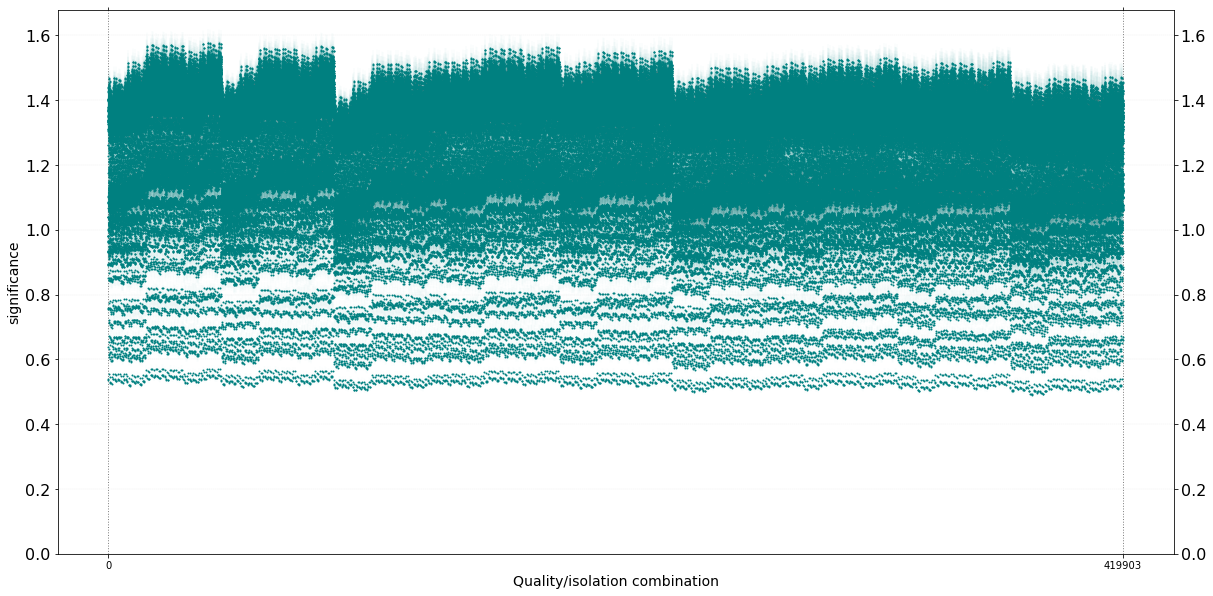

Loosest significance:
0.54 ± 0.01

Maximum significance:
1.58 ± 0.04
at value: 41312



In [11]:
x = range( (n_qualities*n_iso)**2 )

# Uncomment a block:

title = 'significance'
y     = ZW_qual_iso_df['significance']
y_err  = ZW_qual_iso_df['significance-err']
color = 'teal'

# title = 'SF-inZ-significance'
# y     = ZW_qual_iso_df['SF-inZ-significance']
# y_err  = ZW_qual_iso_df['SF-inZ-significance-err']
# color = 'teal'

# title = 'SF-noZ-significance'
# y     = ZW_qual_iso_df['SF-noZ-significance']
# y_err  = ZW_qual_iso_df['SF-noZ-significance-err']
# color = 'teal'

# title = 'DF-significance'
# y     = ZW_qual_iso_df['DF-significance']
# y_err  = ZW_qual_iso_df['DF-significance-err']
# color = 'teal'

# title = 'signal'
# y     = ZW_qual_iso_df['signal']
# y_err  = ZW_qual_iso_df['signal-err']
# color = 'crimson'

# title = 'SF-inZ-signal'
# y     = ZW_qual_iso_df['SF-inZ-signal']
# y_err  = ZW_qual_iso_df['SF-inZ-signal-err']
# color = 'crimson'

# title = 'SF-noZ-signal'
# y     = ZW_qual_iso_df['SF-noZ-signal']
# y_err  = ZW_qual_iso_df['SF-noZ-signal-err']
# color = 'crimson'

# title = 'DF-signal'
# y     = ZW_qual_iso_df['DF-signal']
# y_err  = ZW_qual_iso_df['DF-signal-err']
# color = 'crimson'

# title = 'background'
# y     = ZW_qual_iso_df['background']
# y_err  = ZW_qual_iso_df['background-err']
# color = 'blue'

# title = 'SF-inZ-background'
# y     = ZW_qual_iso_df['SF-inZ-background']
# y_err  = ZW_qual_iso_df['SF-inZ-background-err']
# color = 'blue'

# title = 'SF-noZ-background'
# y     = ZW_qual_iso_df['SF-noZ-background']
# y_err  = ZW_qual_iso_df['SF-noZ-background-err']
# color = 'blue'

# title = 'DF-background'
# y     = ZW_qual_iso_df['DF-background']
# y_err  = ZW_qual_iso_df['DF-background-err']
# color = 'blue'

y = np.array(y)
y_err = np.array(y_err)

plt.figure(figsize=[20,10]) 
plt.plot(x, y, 'o', color=color, markersize=1)
plt.errorbar(x, y, yerr=y_err, 
             fmt=' ', capsize=0, color=color, alpha=0.01)
plt.xlabel("Quality/isolation combination", fontsize=14)
plt.xticks([0,419903])
plt.ylabel(title, fontsize=14)
# plt.yscale('log')
# plt.ylabel('log({})'.format(title), fontsize=14)
plt.ylim(0)
plt.tick_params(bottom=True, top=True, left=True, right=True)
plt.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=True)
plt.yticks(fontsize=16)

plt.grid(axis="x", color="grey", alpha=1, linewidth=1, linestyle=":")
plt.grid(axis="y", color="grey", alpha=.5, linewidth=.25, linestyle=":")
plt.savefig('plots/Using_ZW_leptons_{}_{}.pdf'.format(title, identifier))
plt.show()

print('Loosest significance:'.format(title))
print("{:.2f} ± {:.2f}".format( y[0], y_err[0] ))
print()

print('Maximum significance:'.format(title))
index_max = np.argmax(y)
print("{:.2f} ± {:.2f}".format(y[index_max], y_err[index_max]))
print('at value: {}'.format(index_max))
print()

In [34]:
n_qualities = 9
n_iso_electrons = 6
n_iso_muons = 12

In [13]:
index_max

41312

In [12]:
counter = -1
for Z_quality in range(n_qualities): # qualities: LL, LM, LT, ML, MM, MT, TL, TM, TT
    for Z_i in range(n_iso_electrons): # isolation for electrons, 0 means no iso
        for Z_j in range(n_iso_muons): # isolation for muons, 0 means no iso
            for W_quality in range(n_qualities): # qualities: LL, LM, LT, ML, MM, MT, TL, TM, TT
                for W_i in range(n_iso_electrons): # isolation for electrons, 0 means no iso
                    for W_j in range(n_iso_muons): # isolation for muons, 0 means no iso
                        counter += 1
                        if (counter == index_max):
                            if (Z_quality == 0):
                                print('quality for electrons: loose', '\nquality for muons: loose')
                            if (Z_quality == 1):
                                print('quality for electrons: loose', '\nquality for muons: medium')
                            if (Z_quality == 2):
                                print('quality for electrons: loose', '\nquality for muons: tight')
                            if (Z_quality == 3):
                                print('quality for electrons: medium', '\nquality for muons: loose')
                            if (Z_quality == 4):
                                print('quality for electrons: medium', '\nquality for muons: medium')
                            if (Z_quality == 5):
                                print('quality for electrons: medium', '\nquality for muons: tight')
                            if (Z_quality == 6):
                                print('quality for electrons: tight', '\nquality for muons: loose')
                            if (Z_quality == 7):
                                print('quality for electrons: tight', '\nquality for muons: medium')
                            if (Z_quality == 8):
                                print('quality for electrons: tight', '\nquality for muons: tight')
                            print('isolation for electrons: {}'.format(Z_i))
                            print('isolation for muons: {}'.format(Z_j))
                            if (W_quality == 0):
                                print('quality for electrons: loose', '\nquality for muons: loose')
                            if (W_quality == 1):
                                print('quality for electrons: loose', '\nquality for muons: medium')
                            if (W_quality == 2):
                                print('quality for electrons: loose', '\nquality for muons: tight')
                            if (W_quality == 3):
                                print('quality for electrons: medium', '\nquality for muons: loose')
                            if (W_quality == 4):
                                print('quality for electrons: medium', '\nquality for muons: medium')
                            if (W_quality == 5):
                                print('quality for electrons: medium', '\nquality for muons: tight')
                            if (W_quality == 6):
                                print('quality for electrons: tight', '\nquality for muons: loose')
                            if (W_quality == 7):
                                print('quality for electrons: tight', '\nquality for muons: medium')
                            if (W_quality == 8):
                                print('quality for electrons: tight', '\nquality for muons: tight')
                            print('isolation for electrons: {}'.format(W_i))
                            print('isolation for muons: {}'.format(W_j))


quality for electrons: loose 
quality for muons: loose
isolation for electrons: 5
isolation for muons: 3
quality for electrons: tight 
quality for muons: loose
isolation for electrons: 4
isolation for muons: 8


In [38]:
counter

0

In [22]:
(n_qualities*n_iso)**2

419904

In [23]:
(n_qualities*n_iso)

648

In [27]:
45769/(n_qualities*n_iso)

70.63117283950618

In [29]:
45769 - 70*(n_qualities*n_iso)

409

In [30]:
70/n_qualities

7.777777777777778

In [32]:
70-7*n_qualities

7

# Check values

In [5]:
n_qualities = 9
n_iso = 6*12

In [83]:
Z_quality = 0  # Quality loop (LL, LM, LT, ML, MM, MT, TL, TM, TT)
i         = 5
j         = 3
W_quality = 8
k         = 4
l         = 1

Z_quality = 0  # Quality loop (LL, LM, LT, ML, MM, MT, TL, TM, TT)
i         = 0
j         = 0
W_quality = 4
k         = 4
l         = 1





test_qual_iso_df = pd.DataFrame()

for n, df in zip([0,1],[sig, bkg]):
    
    if (n == 0):
        print("--- analyzing the signal")
    if (n == 1):
        print("--- analyzing the background")
        
    y        = np.zeros(3) # for each SR
    y_err    = np.zeros(3) # for each SR
            
    this_df = df.copy()
    # Check quality
    # LL
    if (Z_quality == 0): 
        pass
    # LM
    elif (Z_quality == 1): 
        this_df = this_df[(abs(this_df.Zlep1_pid) == 11) | (this_df.Zlep1_medium == True)] # medium muons 
        this_df = this_df[(abs(this_df.Zlep2_pid) == 11) | (this_df.Zlep2_medium == True)] # medium muons
    # LT
    elif (Z_quality == 2): 
        this_df = this_df[(abs(this_df.Zlep1_pid) == 11) | (this_df.Zlep1_tight == True)] # tight muons
        this_df = this_df[(abs(this_df.Zlep2_pid) == 11) | (this_df.Zlep2_tight == True)] # tight muons
    # ML
    elif (Z_quality == 3): 
        this_df = this_df[(abs(this_df.Zlep1_pid) == 13) | (this_df.Zlep1_medium == True)] # medium electrons
        this_df = this_df[(abs(this_df.Zlep2_pid) == 13) | (this_df.Zlep2_medium == True)] # medium electrons
    # MM
    elif (Z_quality == 4): 
        this_df = this_df[this_df.Zlep1_medium == True] # medium all
        this_df = this_df[this_df.Zlep2_medium == True] # medium all
    # MT
    elif (Z_quality == 5): 
        this_df = this_df[(abs(this_df.Zlep1_pid) == 13) | (this_df.Zlep1_medium == True)] # medium electrons
        this_df = this_df[(abs(this_df.Zlep1_pid) == 11) | (this_df.Zlep1_tight == True)]  # tight muons
        this_df = this_df[(abs(this_df.Zlep2_pid) == 13) | (this_df.Zlep2_medium == True)] # medium electrons
        this_df = this_df[(abs(this_df.Zlep2_pid) == 11) | (this_df.Zlep2_tight == True)]  # tight muons
    # TL
    elif (Z_quality == 6): 
        this_df = this_df[(abs(this_df.Zlep1_pid) == 13) | (this_df.Zlep1_tight == True)] # tight electrons
        this_df = this_df[(abs(this_df.Zlep2_pid) == 13) | (this_df.Zlep2_tight == True)] # tight electrons
    # TM
    elif (Z_quality == 7):
        this_df = this_df[(abs(this_df.Zlep1_pid) == 13) | (this_df.Zlep1_tight == True)]  # tight electrons
        this_df = this_df[(abs(this_df.Zlep1_pid) == 11) | (this_df.Zlep1_medium == True)] # medium muons 
        this_df = this_df[(abs(this_df.Zlep2_pid) == 13) | (this_df.Zlep2_tight == True)]  # tight electrons
        this_df = this_df[(abs(this_df.Zlep2_pid) == 11) | (this_df.Zlep2_medium == True)] # medium muons
    # TT
    elif (Z_quality == 8):
        this_df = this_df[this_df.Zlep1_tight == True] # tight all
        this_df = this_df[this_df.Zlep2_tight == True] # tight all

    # Isolation loop for electrons, 0 means no iso

    if (i == 0):
        pass
    else:
        this_df = this_df[(abs(this_df.Zlep1_pid) == 13) | (this_df['Zlep1_iso_{}'.format(i)] == True)] # iso_i electrons
        this_df = this_df[(abs(this_df.Zlep2_pid) == 13) | (this_df['Zlep2_iso_{}'.format(i)] == True)] # iso_i electrons

    # Isolation loop for muons, 0 means no iso

    if (j == 0):
        pass
    else:
        this_df = this_df[(abs(this_df.Zlep1_pid) == 11) | (this_df['Zlep1_iso_{}'.format(j)] == True)] # iso_j muons
        this_df = this_df[(abs(this_df.Zlep2_pid) == 11) | (this_df['Zlep2_iso_{}'.format(j)] == True)] # iso_j muons


    # ---------- W lepton analysis ----------

    # Quality loop (LL, LM, LT, ML, MM, MT, TL, TM, TT)

    # Check quality
    # LL
    if (W_quality == 0): 
        pass
    # LM
    elif (W_quality == 1): 
        this_df = this_df[(abs(this_df.Wlep1_pid) == 11) | (this_df.Wlep1_medium == True)] # medium muons 
        this_df = this_df[(abs(this_df.Wlep2_pid) == 11) | (this_df.Wlep2_medium == True)] # medium muons
    # LT
    elif (W_quality == 2): 
        this_df = this_df[(abs(this_df.Wlep1_pid) == 11) | (this_df.Wlep1_tight == True)] # tight muons
        this_df = this_df[(abs(this_df.Wlep2_pid) == 11) | (this_df.Wlep2_tight == True)] # tight muons
    # ML
    elif (W_quality == 3): 
        this_df = this_df[(abs(this_df.Wlep1_pid) == 13) | (this_df.Wlep1_medium == True)] # medium electrons
        this_df = this_df[(abs(this_df.Wlep2_pid) == 13) | (this_df.Wlep2_medium == True)] # medium electrons
    # MM
    elif (W_quality == 4): 
        this_df = this_df[this_df.Wlep1_medium == True] # medium all
        this_df = this_df[this_df.Wlep2_medium == True] # medium all
    # MT
    elif (W_quality == 5): 
        this_df = this_df[(abs(this_df.Wlep1_pid) == 13) | (this_df.Wlep1_medium == True)] # medium electrons
        this_df = this_df[(abs(this_df.Wlep1_pid) == 11) | (this_df.Wlep1_tight == True)]  # tight muons
        this_df = this_df[(abs(this_df.Wlep2_pid) == 13) | (this_df.Wlep2_medium == True)] # medium electrons
        this_df = this_df[(abs(this_df.Wlep2_pid) == 11) | (this_df.Wlep2_tight == True)]  # tight muons
    # TL
    elif (W_quality == 6): 
        this_df = this_df[(abs(this_df.Wlep1_pid) == 13) | (this_df.Wlep1_tight == True)] # tight electrons
        this_df = this_df[(abs(this_df.Wlep2_pid) == 13) | (this_df.Wlep2_tight == True)] # tight electrons
    # TM
    elif (W_quality == 7):
        this_df = this_df[(abs(this_df.Wlep1_pid) == 13) | (this_df.Wlep1_tight == True)]  # tight electrons
        this_df = this_df[(abs(this_df.Wlep1_pid) == 11) | (this_df.Wlep1_medium == True)] # medium muons 
        this_df = this_df[(abs(this_df.Wlep2_pid) == 13) | (this_df.Wlep2_tight == True)]  # tight electrons
        this_df = this_df[(abs(this_df.Wlep2_pid) == 11) | (this_df.Wlep2_medium == True)] # medium muons
    # TT
    elif (W_quality == 8):
        this_df = this_df[this_df.Wlep1_tight == True] # tight all
        this_df = this_df[this_df.Wlep2_tight == True] # tight all

    # Isolation loop for electrons, 0 means no iso

    if (k == 0):
        pass
    else:
        this_df = this_df[(abs(this_df.Wlep1_pid) == 13) | (this_df['Wlep1_iso_{}'.format(k)] == True)] # iso_k W electrons
        this_df = this_df[(abs(this_df.Wlep2_pid) == 13) | (this_df['Wlep2_iso_{}'.format(k)] == True)] # iso_k W electrons

    # Isolation loop for muons, 0 means no iso

    if (l == 0):
        pass
    else:
        this_df = this_df[(abs(this_df.Wlep1_pid) == 11) | (this_df['Wlep1_iso_{}'.format(l)] == True)] # iso_l W muons
        this_df = this_df[(abs(this_df.Wlep2_pid) == 11) | (this_df['Wlep2_iso_{}'.format(l)] == True)] # iso_l W muons

    for SR in [0,1,2]:

        sr_df = this_df[this_df.SR == SR].copy()

        y[SR]    = sum(sr_df['wgt'])
        y_err[SR] = sum(sr_df['wgt']**2)


    y_err[0] = np.sqrt(y_err[0])
    y_err[1] = np.sqrt(y_err[1])
    y_err[2] = np.sqrt(y_err[2])

    # Saving information:
    if (n == 0):
        test_qual_iso_df['SF-inZ-signal']     = pd.Series(y[0])
        test_qual_iso_df['SF-inZ-signal-err'] = pd.Series(y_err[0])
        test_qual_iso_df['SF-noZ-signal']     = pd.Series(y[1])
        test_qual_iso_df['SF-noZ-signal-err'] = pd.Series(y_err[1])
        test_qual_iso_df['DF-signal']         = pd.Series(y[2])
        test_qual_iso_df['DF-signal-err']     = pd.Series(y_err[2])
        test_qual_iso_df['signal']            = pd.Series(y[0]+y[1]+y[2])
        test_qual_iso_df['signal-err']        = pd.Series(np.sqrt(y_err[0]**2 + y_err[1]**2 + y_err[2]**2))
        
    if (n == 1):
        test_qual_iso_df['SF-inZ-background']     = pd.Series(y[0])
        test_qual_iso_df['SF-inZ-background-err'] = pd.Series(y_err[0])
        test_qual_iso_df['SF-noZ-background']     = pd.Series(y[1])
        test_qual_iso_df['SF-noZ-background-err'] = pd.Series(y_err[1])
        test_qual_iso_df['DF-background']         = pd.Series(y[2])
        test_qual_iso_df['DF-background-err']     = pd.Series(y_err[2])
        test_qual_iso_df['background']            = pd.Series(y[0]+y[1]+y[2])
        test_qual_iso_df['background-err']        = pd.Series(np.sqrt(y_err[0]**2 + y_err[1]**2 + y_err[2]**2))
        
        
# Calculating the significances
print("Calculating the significances")
significances = [[],[],[],[]] 
errors = [[],[],[],[]]

for choice in test_qual_iso_df.index:

    # SF-inZ
    significance, error = significance_and_error(test_qual_iso_df.at[choice,'SF-inZ-signal'], \
                                                 test_qual_iso_df.at[choice,'SF-inZ-signal-err'], \
                                                 test_qual_iso_df.at[choice,'SF-inZ-background'], \
                                                 test_qual_iso_df.at[choice,'SF-inZ-background-err'])
    significances[0].append(significance)
    errors[0].append(error)
    # SF-noZ
    significance, error = significance_and_error(test_qual_iso_df.at[choice,'SF-noZ-signal'], \
                                                 test_qual_iso_df.at[choice,'SF-noZ-signal-err'], \
                                                 test_qual_iso_df.at[choice,'SF-noZ-background'], \
                                                 test_qual_iso_df.at[choice,'SF-noZ-background-err'])
    significances[1].append(significance)
    errors[1].append(error)
    # DF
    significance, error = significance_and_error(test_qual_iso_df.at[choice,'DF-signal'], \
                                                 test_qual_iso_df.at[choice,'DF-signal-err'], \
                                                 test_qual_iso_df.at[choice,'DF-background'], \
                                                 test_qual_iso_df.at[choice,'DF-background-err'])
    significances[2].append(significance)
    errors[2].append(error)
    # Quadrature
    significance, error = add_in_quadrature_3((significances[0][-1], errors[0][-1]), 
                                              (significances[1][-1], errors[1][-1]),
                                              (significances[2][-1], errors[2][-1]),)
    significances[3].append(significance)
    errors[3].append(error)
    
test_qual_iso_df['SF-inZ-significance']     = pd.Series(significances[0])
test_qual_iso_df['SF-inZ-significance-err'] = pd.Series(errors[0])
test_qual_iso_df['SF-noZ-significance']     = pd.Series(significances[1])
test_qual_iso_df['SF-noZ-significance-err'] = pd.Series(errors[1])
test_qual_iso_df['DF-significance']         = pd.Series(significances[2])
test_qual_iso_df['DF-significance-err']     = pd.Series(errors[2])
test_qual_iso_df['significance']            = pd.Series(significances[3])
test_qual_iso_df['significance-err']        = pd.Series(errors[3])
print("--- Done!")

--- analyzing the signal
--- analyzing the background
Calculating the significances
--- Done!


In [84]:
test_qual_iso_df['significance']

0    1.509569
Name: significance, dtype: float64